In [2]:
import numpy as np
from scipy.integrate import quad
from scipy.special import erf, erfc, erfcx
import pandas as pd
import matplotlib.pyplot as plt
#import tqdm
import seaborn as sns
import lzma
import pickle

In [3]:
from scipy.integrate import quad
from scipy.special import erfc

def channel(y, w, v, var_noise, c=0):
    """Compute g and g' for probit channel"""
    
    phi = -y * (w+c) / np.sqrt(2 * (v + var_noise))
    g = 2 * y / (np.sqrt(2 * np.pi * (v + var_noise)) * erfcx(phi))
    dg = -g * ((w+c) / (v + var_noise) + g)
    
    return g, dg


def iterate_se(rows_to_columns,c, var_noise, v0=1, max_iter=250, tol=1e-11, verbose=1):
    """Iterates state evolution associated to AMP implementation above"""
    
    # Define function to be integrated at each step
    f = lambda a: lambda z: np.exp(-z ** 2 / 2) / np.sqrt(2 * np.pi) * \
            (1 - np.tanh(a + np.sqrt(a) * z) ** 2)
        
    def int_g(v):
        var = .5 * (1 - v) / (v + var_noise)
        g0 = lambda z: erfc(-z) * channel(+1, np.sqrt(2 * (v + var_noise)) * z, v, var_noise,c)[1]
        if var == 0:
            return g0(0)
        else:
            g = lambda z: np.exp(-.5 * z ** 2 / var) / np.sqrt(2 * np.pi * var) * g0(z)
            return quad(g, -10, 10)[0]
    
    v = np.zeros(max_iter)
    v[0] = v0
    
    for t in range(max_iter - 1):
        a = -rows_to_columns * int_g(v[t])
        v[t + 1] = quad(f(a), -10, 10)[0]
        
        diff = np.abs(v[t + 1] - v[t])
        if verbose:
            print("t = %d, diff = %g; v = %g" % (t, diff, v[t + 1]))
            
        if diff < tol:
            break

    return v[:t + 1]

def find_spinodal(tol=1e-4, threshold=1e-5, verbose=1,c=0):
    """Determines algorithmic transition by performing binary search"""
    
    # Returns True if solution has been found
    f = lambda x: (iterate_se(x, c,1e-10, max_iter=1000, verbose=0)[-1] < threshold)
    
    # Perform binary search
    alpha_l, alpha_r = 0, 10
    f_l, f_r = f(alpha_l), f(alpha_r)
    while alpha_r - alpha_l > tol:
        alpha_m = .5 * (alpha_l + alpha_r)
        f_m = f(alpha_m)
        if verbose:
            print("alpha = %g, found solution = %s" % (alpha_m, f_m))
        
        if f_m:
            alpha_r = alpha_m
        else:
            alpha_l = alpha_m
            
    return .5 * (alpha_l + alpha_r)

from scipy.integrate import quad

def phi(v, rows_to_columns, var_noise=1e-10,c=0):
    """Compute replica free energy for Ising perceptron"""
    
    # Compute A(V) using SE iteration
    dg0 = lambda z: erfc(-z) * channel(+1, np.sqrt(2 * (v + var_noise)) * z, v, var_noise,c)[1]
    var = .5 * (1 - v) / (v + var_noise)
    if var == 0:
        a = -rows_to_columns * dg0(0)
    else:
        dg = lambda z: np.exp(-.5 * z ** 2 / var) / np.sqrt(2 * np.pi * var) * dg0(z)
        a = -rows_to_columns * quad(dg, -10, 10)[0]    
    
    # Compute <log Z_z>
    lnzz0 = lambda z: erfc(z) * np.log(.5 * erfc(z))
    if var == 0:
        avg_lnzz = lnzz0(0)
    else:
        lnzz = lambda z: np.exp(-.5 * z ** 2 / var) / np.sqrt(2 * np.pi * var) * lnzz0(z)
        avg_lnzz = quad(lnzz, -10, 10)[0]

    # Compute <log Z_x>
    lnzx = lambda z: np.exp(-.5 * z ** 2) / np.sqrt(2 * np.pi) * \
            (np.log(np.cosh(a + np.sqrt(a) * z)) if np.abs(a + np.sqrt(a) * z) < 100 else \
                np.abs(a + np.sqrt(a) * z) - np.log(2))
    avg_lnzx = -.5 * a + quad(lnzx, -10, 10)[0]
    
    return .5 * a * (1 - v) - rows_to_columns * avg_lnzz - avg_lnzx

def find_critical(c=0,tol=1e-4, threshold=1e-5, verbose=1):
    """Determines IT transition by performing binary search"""
    
    # Returns True if free energy of bad minimum is larger than free energy at zero
    f = lambda x: phi(iterate_se(x,c, 1e-10, verbose=0)[-1], x) > phi(0, x)
    
    # Perform binary search
    alpha_l, alpha_r = 0, 1.49
    f_l, f_r = f(alpha_l), f(alpha_r)
    while alpha_r - alpha_l > tol:
        alpha_m = .5 * (alpha_l + alpha_r)
        f_m = f(alpha_m)
        if verbose:
            print("alpha = %g, found solution = %s" % (alpha_m, f_m))
        
        if f_m:
            alpha_r = alpha_m
        else:
            alpha_l = alpha_m
            
    return .5 * (alpha_l + alpha_r)

In [192]:
find_spinodal(c=0)

alpha = 5, found solution = True
alpha = 2.5, found solution = True
alpha = 1.25, found solution = False
alpha = 1.875, found solution = True
alpha = 1.5625, found solution = True
alpha = 1.40625, found solution = False
alpha = 1.48438, found solution = False
alpha = 1.52344, found solution = True
alpha = 1.50391, found solution = True
alpha = 1.49414, found solution = True
alpha = 1.48926, found solution = False
alpha = 1.4917, found solution = False
alpha = 1.49292, found solution = True
alpha = 1.49231, found solution = False
alpha = 1.49261, found solution = False
alpha = 1.49277, found solution = True
alpha = 1.49269, found solution = True


1.4926528930664062

# Compute $\alpha_C$

In [246]:
def q_integrand(xi,q_hat):
    absx = np.abs(xi*np.sqrt(q_hat))
    logI= -0.5 * q_hat + absx + 2*np.log1p(-np.exp(-2*absx)) - np.log1p(np.exp(-2*absx)) - np.log(2)
    return np.exp(logI)* np.exp(-xi**2/2) / np.sqrt(2 * np.pi)
def q_(q_hat):
    #if q_hat >30: q = 1 
    #else: q = quad(lambda xi: q_integrand(xi,q_hat), -20, 20,epsrel = 1e-9)[0]
    return quad(lambda xi: q_integrand(xi,q_hat), -20, 20,epsrel = 1e-9)[0]

In [261]:
eps = 1e-20
def qhat_integrand(xi,q,c):
    x = -(xi*np.sqrt(q) + c)/np.sqrt(2*(1-q))
    #if (x<-24): I = np.sqrt(np.pi)*np.exp(xi**2*(1-(1+q)/(2*q)))*(-x - 1/(2*x) + 1/(2*x**3) - 5/(4*x**5))
    #if (x < -24): I = 0
    #else:  
    I = np.exp(-x**2) / (erfcx(-x)+eps)

    return I* np.exp(-xi**2 / 2) / np.sqrt(2 * np.pi)

def qhat_(q,c):
    if q > 0.999:
        return 100
    else:
        expectation = quad(lambda xi: qhat_integrand(xi,q,c), -10, 10)[0]
        return 2*expectation/(np.pi*(1-q))


In [262]:
qhat_(0.9994,c=1)

100

In [285]:
#alpha_values = [1.0, 2.0, 4.0, 10.0, 20.0, 40.0]  
alpha_values = np.linspace(7.9565,7.958,16)
c=2.#c_values = [0.]  
tolerance = 1e-5
#max_iter = 1000  

results = []

for alpha in tqdm.tqdm(alpha_values):
#for c in c_values:
    q = 1e-5
    q_old = q + 2*tolerance 
    q_hat_old = 1e-6#qhat_(q,c)
    i=0
    while (((q<1-1e-2) & (abs(q - q_old) > tolerance)) or i ==0):
        i+=1
        q_old = q

        q_hat = alpha * (1 * qhat_(q,c) + 0 * q_hat_old)
        q_hat_old = q_hat
        q_new = q_(q_hat)
        if q_new == 1:
            q = 1
            break
        else:
            q = q*0.95 + q_new*0.05
        #print("i = ", i, "q_old = ", q_old, "q_hat = ", q_hat, "q = ", q, "alpha = ", alpha)
        #if i % 1000 == 0:
        #    print(f"Iteration {i}: alpha = {alpha}, q = {q}, q_hat = {q_hat}")
        if i > 10000:
            print("Warning: Maximum iterations reached without convergence.")
            break
    results.append({'alpha': alpha, 'c': c, 'q': q, 'i': i})
    print(f"alpha = {alpha}, c = {c}, q = {q}, iterations = {i}")


  0%|          | 0/16 [00:00<?, ?it/s]

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_3459/3796443087.py:3: RuntimeWarning: divide by zero encountered in log1p
  logI= -0.5 * q_hat + absx + 2*np.log1p(-np.exp(-2*absx)) - np.log1p(np.exp(-2*absx)) - np.log(2)
  6%|▋         | 1/16 [00:02<00:30,  2.02s/it]

alpha = 7.9565, c = 2.0, q = 0.9501283656920404, iterations = 935


 12%|█▎        | 2/16 [00:03<00:27,  1.97s/it]

alpha = 7.9566, c = 2.0, q = 0.9502311705634906, iterations = 942


 19%|█▉        | 3/16 [00:05<00:25,  1.97s/it]

alpha = 7.9567000000000005, c = 2.0, q = 0.9503344592156117, iterations = 949


 25%|██▌       | 4/16 [00:08<00:24,  2.01s/it]

alpha = 7.9568, c = 2.0, q = 0.9504582691316481, iterations = 958


 31%|███▏      | 5/16 [00:09<00:21,  1.98s/it]

alpha = 7.9569, c = 2.0, q = 0.9505826791031395, iterations = 967


 38%|███▊      | 6/16 [00:12<00:20,  2.02s/it]

alpha = 7.957, c = 2.0, q = 0.9507177662674712, iterations = 977


 44%|████▍     | 7/16 [00:14<00:18,  2.01s/it]

alpha = 7.9571000000000005, c = 2.0, q = 0.9508736429534561, iterations = 989


 50%|█████     | 8/16 [00:16<00:16,  2.04s/it]

alpha = 7.9572, c = 2.0, q = 0.9510604860862865, iterations = 1004


 56%|█████▋    | 9/16 [00:18<00:14,  2.04s/it]

alpha = 7.9573, c = 2.0, q = 0.9513086112923561, iterations = 1025


 62%|██████▎   | 10/16 [00:22<00:16,  2.70s/it]

alpha = 7.9574, c = 2.0, q = 0.990174908584964, iterations = 1972


 69%|██████▉   | 11/16 [00:26<00:15,  3.13s/it]

alpha = 7.9575000000000005, c = 2.0, q = 0.990170914634463, iterations = 1964


 75%|███████▌  | 12/16 [00:30<00:13,  3.43s/it]

alpha = 7.9576, c = 2.0, q = 0.9901412572083923, iterations = 1956


 81%|████████▏ | 13/16 [00:34<00:10,  3.63s/it]

alpha = 7.9577, c = 2.0, q = 0.990086426244388, iterations = 1948


 88%|████████▊ | 14/16 [00:38<00:07,  3.82s/it]

alpha = 7.9578, c = 2.0, q = 0.990006891851377, iterations = 1940


 94%|█████████▍| 15/16 [00:43<00:03,  3.91s/it]

alpha = 7.9579, c = 2.0, q = 0.990173082253742, iterations = 1933


100%|██████████| 16/16 [00:47<00:00,  2.94s/it]

alpha = 7.958, c = 2.0, q = 0.990045636276336, iterations = 1925


In [142]:
#results

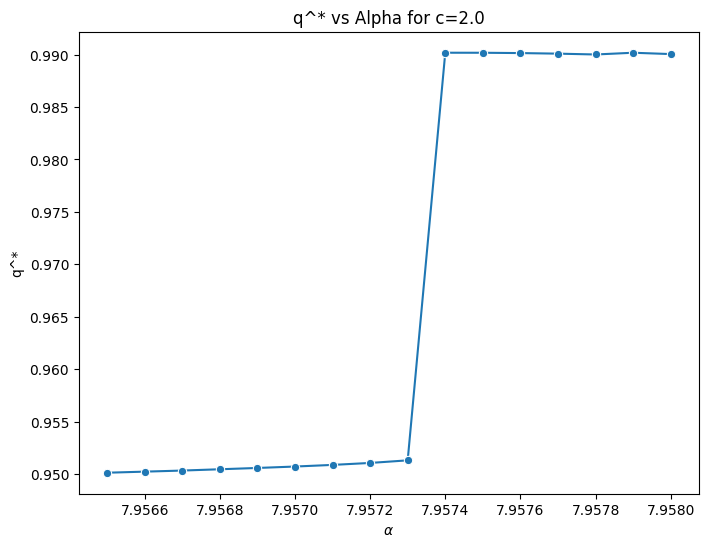

In [286]:
import seaborn as sns
results_df = pd.DataFrame(results)

plt.figure(figsize=(8, 6))
subset = results_df[results_df['c'] == c]
sns.lineplot(data=subset, x='alpha', y='q', marker='o')

plt.title(f'q^* vs Alpha for c={c}')
plt.xlabel(r'$\alpha$')
plt.ylabel('q^*')
#plt.ylim(0, 1) 
plt.show()

- c=-1 : alpha=3.241
- c=0 : alpha=1.493
- c=1 : alpha=2.043

In [45]:
alpha_amp_tab = [3.241,1.493,2.043]
alpha_c0_tab = [2,4,10,20,40]
rho_c0_tab=[0.705,0.335,0.13,0.065,0.035]
rho_cm1_tab=[0.645,0.265,0.135,0.075]
alpha_cm1_tab=[4,10,20,40]

alpha_c1_tab = [4,10,20,40]
rho_c1_tab=[0.255,0.085,0.04,0.025]
err_rho=0.005

# OLD Plots

In [8]:
alpha_amp_tab[0]

3.241

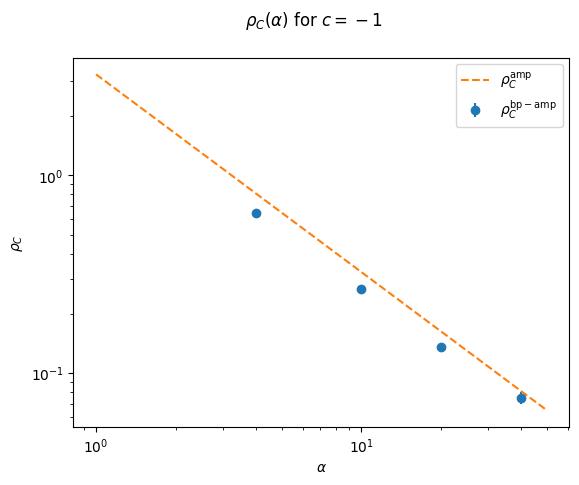

In [9]:
fig, ax = plt.subplots()
fig.suptitle(r'$\rho_C(\alpha)$ for $c=-1$')
plt.errorbar(alpha_cm1_tab,rho_cm1_tab,yerr=err_rho,fmt='o',label=r'$\rho_C^{\rm bp-amp}$')
plt.plot(np.linspace(1,50,100),alpha_amp_tab[0]/np.linspace(1,50,100),'--',label=r'$\rho_C^{\rm amp}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\rho_C$')
plt.legend()

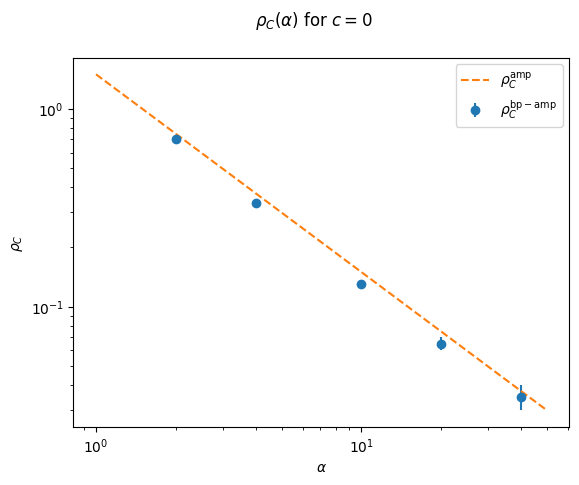

In [10]:
fig, ax = plt.subplots()
fig.suptitle(r'$\rho_C(\alpha)$ for $c=0$')
plt.errorbar(alpha_c0_tab,rho_c0_tab,yerr=err_rho,fmt='o',label=r'$\rho_C^{\rm bp-amp}$')
plt.plot(np.linspace(1,50,100),alpha_amp_tab[1]/np.linspace(1,50,100),'--',label=r'$\rho_C^{\rm amp}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\rho_C$')
plt.legend()

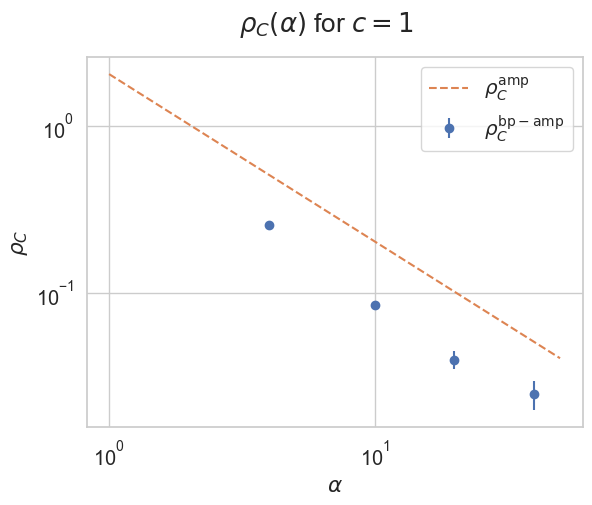

In [207]:
fig, ax = plt.subplots()
fig.suptitle(r'$\rho_C(\alpha)$ for $c=1$')
plt.errorbar(alpha_c1_tab,rho_c1_tab,yerr=err_rho,fmt='o',label=r'$\rho_C^{\rm bp-amp}$')
plt.plot(np.linspace(1,50,100),alpha_amp_tab[2]/np.linspace(1,50,100),'--',label=r'$\rho_C^{\rm amp}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\rho_C$')
plt.legend()

In [585]:
alpha_amp_tab[1]

1.493

In [64]:
a_ll = np.array([1,3,6,12,24])
print(a_ll)

[ 1  3  6 12 24]


In [65]:
#a_ll = np.logspace(0,2,19,base=10)
for i,a in enumerate(a_ll):
    print(i, int(10000*a**0.5), int(10000*a**(-0.5)), a_ll[i], i, int(10000*a**0.5), int(10000*a**(-0.5)))

0 10000 10000 1 0 10000 10000
1 17320 5773 3 1 17320 5773
2 24494 4082 6 2 24494 4082
3 34641 2886 12 3 34641 2886
4 48989 2041 24 4 48989 2041


In [67]:
print((50000*a_ll**0.5)[:].astype(int))

[ 50000  86602 122474 173205 244948]


In [69]:
print((50000*a_ll**-0.5)[:].astype(int))

[50000 28867 20412 14433 10206]


In [80]:
173206/14434

11.99986143827075

In [277]:
print(a_ll)

[  1.           1.29154967   1.66810054   2.15443469   2.7825594
   3.59381366   4.64158883   5.9948425    7.74263683  10.
  12.91549665  16.68100537  21.5443469   27.82559402  35.93813664
  46.41588834  59.94842503  77.42636827 100.        ]


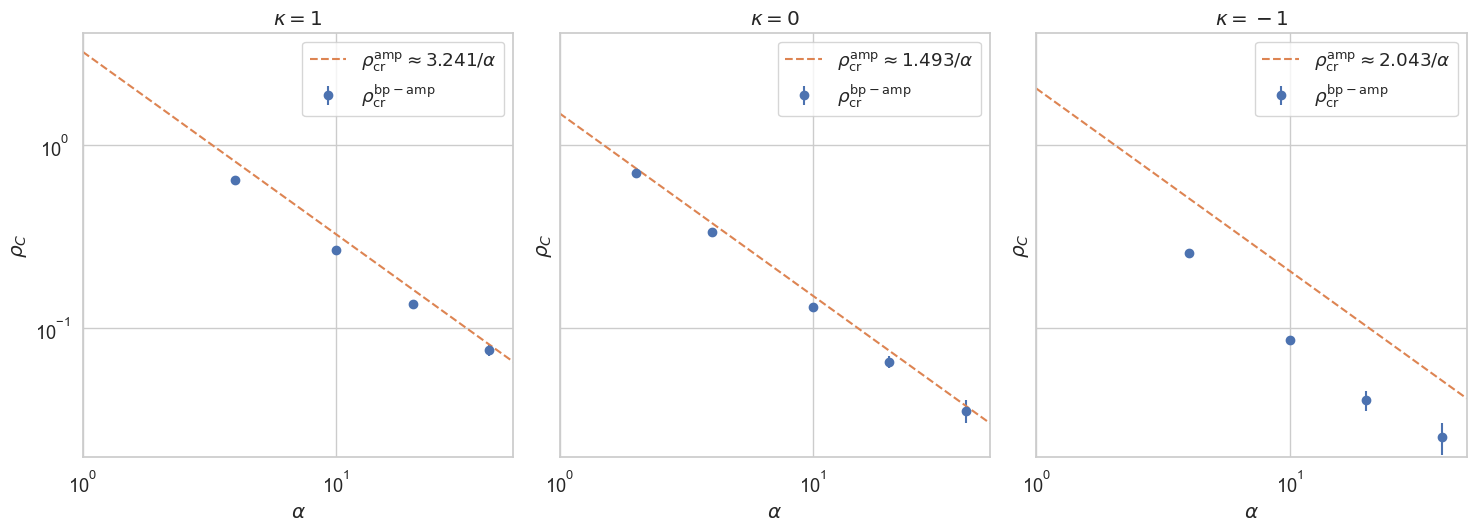

In [14]:
sns.set(style="whitegrid", font_scale=1.2)
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True) 
x = np.linspace(1,50,100)
#fig.suptitle(r'$\rho_C(\alpha)$')

axs[0].errorbar(alpha_cm1_tab,rho_cm1_tab,yerr=err_rho,fmt='o',label=r'$\rho_{\rm cr}^{\rm bp-amp}$')
axs[0].plot(x,alpha_amp_tab[0]/x,'--',label=r'$\rho_{\rm cr}^{\rm amp}\approx 3.241/\alpha$')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$\alpha$')
axs[0].set_ylabel(r'$\rho_C$')
axs[0].legend()
axs[0].set_title(r'$\kappa=1$')
axs[0].set_xlim(1,50)

axs[1].errorbar(alpha_c0_tab,rho_c0_tab,yerr=err_rho,fmt='o',label=r'$\rho_{\rm cr}^{\rm bp-amp}$')
axs[1].plot(x,alpha_amp_tab[1]/x,'--',label=r'$\rho_{\rm cr}^{\rm amp}\approx 1.493/\alpha$')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\alpha$')
axs[1].set_ylabel(r'$\rho_C$')
axs[1].legend()
axs[1].set_title(r'$\kappa=0$')
axs[1].set_xlim(1,50)

axs[2].errorbar(alpha_c1_tab,rho_c1_tab,yerr=err_rho,fmt='o',label=r'$\rho_{\rm cr}^{\rm bp-amp}$')
axs[2].plot(x,alpha_amp_tab[2]/x,'--',label=r'$\rho_{\rm cr}^{\rm amp}\approx 2.043/\alpha$')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'$\alpha$')
axs[2].set_ylabel(r'$\rho_C$')
axs[2].legend()
axs[2].set_title(r'$\kappa=-1$')
axs[2].set_xlim(1,50)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
fig.savefig('rho_c_alpha.pdf')

In [51]:
def maxWidthRamp(nums):
    """
    :type nums: List[int]
    :rtype: int
    """
    i_list = [0]
    l = len(nums)
    j_list = [l-1]

    for i in range(1,l):
        if (nums[i] < nums[i_list[-1]]): 
            i_list.append(i)
            if (nums[i]==0): break
    for j in range(1,l):
        if (nums[l-j-1] > nums[j_list[-1]]): j_list.append(l-j-1)

    r=0        
    li = len(i_list)
    print(i_list)
    lj = len(j_list)
    print(j_list)
    print('i')
    for ki in range(li): print(nums[i_list[ki]])
    print('j')
    for kj in range(lj): print(nums[j_list[kj]])
    for ki in range(li):
        for kj in list(reversed(range(lj))):
            if (nums[i_list[ki]] > nums[j_list[kj]]):
                print(ki,kj)
                if (kj!=lj):
                    r = max(r, j_list[kj+1] - i_list[ki])
                    lj = kj+1
                break
        #for kj in range(lj):
        #    if (nums[i_list[ki]] <= nums[j_list[kj]]):
        #        r = max(r, j_list[kj] - i_list[ki])
        #        lj = kj

    return r

In [52]:
nums = [6,0,8,2,1,5]
#nums = [99,98,94,92,91,91,91,90,90,89,89,67,89,89,89,89,87,85,83,52,18,80,80,79,79,78,72,72,72,76,69,69,67,66,65,62,60,60,59,59,59,58,58,58,53,53,52,52,51,0,50,50,50,48,47,44,42,42,42,41,40,39,38,35,33,42,40,29,29,29,28,27,26,23,22,21,19,90,96,16,16,16,16,16,13,13,12,12,9,9,9,7,3,2,2,2,2,1,1,0]
maxWidthRamp(nums)

[0, 1]
[5, 2]
i
6
0
j
5
8
0 0


2

In [24]:
nums = [99,98,94,92,91,91,91,90,90,89,89,67,89,89,89,89,87,85,83,52,18,80,80,79,79,78,72,72,72,76,69,69,67,66,65,62,60,60,59,59,59,58,58,58,53,53,52,52,51,0,50,50,50,48,47,44,42,42,42,41,40,39,38,35,33,42,40,29,29,29,28,27,26,23,22,21,19,90,96,16,16,16,16,16,13,13,12,12,9,9,9,7,3,2,2,2,2,1,1,0]
i_list = [0, 1, 2, 3, 4, 7, 9, 11, 19, 20, 49]
li = len(i_list)
j_list = [99, 98, 96, 92, 91, 90, 87, 85, 83, 78, 1, 0]
lj = len(j_list)
r=0
for k in range(li+lj):
    for m in range(k+1):
        if(nums[i_list[m]] <= nums[j_list[k-m]]):
            if (j_list[k-m] - i_list[m] > r) : r = j_list[k-m] - i_list[m]
    if (r>0): break
print(r)


50


# Finite sizes

In [1290]:
load_Dir = "./CLUSTER/DataCxtEpi/FiniteSize/"

In [1291]:
#file_name = "DF_20250217-c0_a2.xz"
file_name = "DF_20250515-133150_927.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame_tot = pickle.load(f)

In [1292]:
data_frame_tot.iloc[:,-10:]

,$SE_{RND}$,$MSE_{RND}$,$\delta SE$,$R_{SE}$,$R_{MSE}$,$\delta R_{SE}$,ConvChecks,free_entropy_BP,free_entropy_AMP,total_free_entropy
0,0.368483,0.372733,-0.008125,0.499951,0.483855,0.016097,"[[10, 0.0027871264562063236, 7.411738324673112...",NaN,NaN,NaN
1,0.368483,0.372733,-0.008142,0.499987,0.483845,0.016142,"[[10, 0.003333069599263272, 2.7766170515096234...",NaN,NaN,NaN
2,0.360393,0.360571,-0.002233,0.995620,0.989429,0.006192,"[[10, 0.03354011726184003, 2.7866881516545675e...",NaN,NaN,NaN
3,0.360393,0.360629,-0.001203,0.997867,0.994533,0.003334,"[[10, 0.0066955945375579695, 4.124731875815525...",NaN,NaN,NaN
4,0.379902,0.380954,0.236701,0.372606,0.995674,-0.623069,"[[10, 0.008121678996450193, 3.510851033982946e...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5661,0.378723,0.380407,-0.013963,0.666221,0.630992,0.035229,"[[10, 0.00727279932779526, 5.841509025452746e-...",NaN,NaN,NaN
5662,0.378723,0.380401,-0.014047,0.666422,0.630967,0.035454,"[[10, 0.01617191064033953, 7.80030408654485e-0...",NaN,NaN,NaN
5663,0.376003,0.373543,0.001888,0.495130,0.496860,-0.001730,"[[10, 0.00410097260001345, 8.065582581876636e-...",0.609077,-0.677822,-0.068744
5664,0.376024,0.378146,-0.000120,0.571553,0.573641,-0.002088,"[[10, 0.002377700518431211, 2.4973409598543784...",NaN,NaN,NaN


In [1293]:
data_frame_tot = data_frame_tot[(data_frame_tot['init']=="rnd") & ( (data_frame_tot[r"$N$"]==10000) | (data_frame_tot[r"$N$"]==40000) | (data_frame_tot[r"$N$"]==160000) )]
data_frame_tot[r"$\rho$"] = data_frame_tot["M"]

In [1294]:
data_frame_tot[r"$M$"]

4        1000
6        1000
12       4000
14       4000
16       4000
        ...  
5651     1000
5653     1000
5655     4000
5659     4000
5663    16000
Name: $M$, Length: 1470, dtype: int64

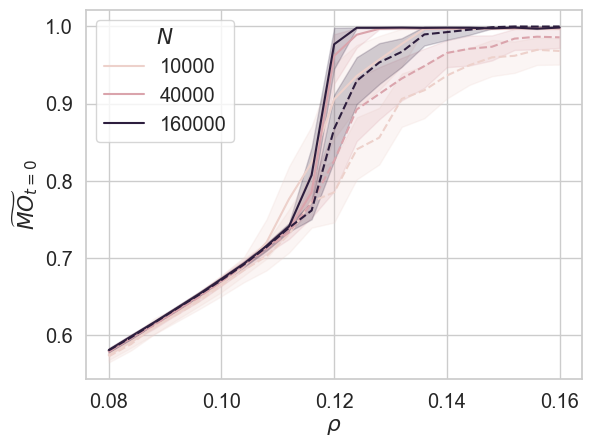

<Figure size 640x480 with 0 Axes>

In [1295]:
sns.set_theme(style="whitegrid",font_scale=1.3)
y_s = "$\widetilde{MO}_{t=0}$"
sns.lineplot(data=data_frame_tot,x=r"$\rho$",y=y_s, hue=r"$N$")
y_s = "$\widetilde{O}_{t=0}$"
sns.lineplot(data=data_frame_tot,x=r"$\rho$",y=y_s, hue=r"$N$", linestyle="--",legend=False)
plt.show()
plt.savefig("MO_N_rho.pdf")

<Axes: xlabel='$\\rho$', ylabel='Nishi'>

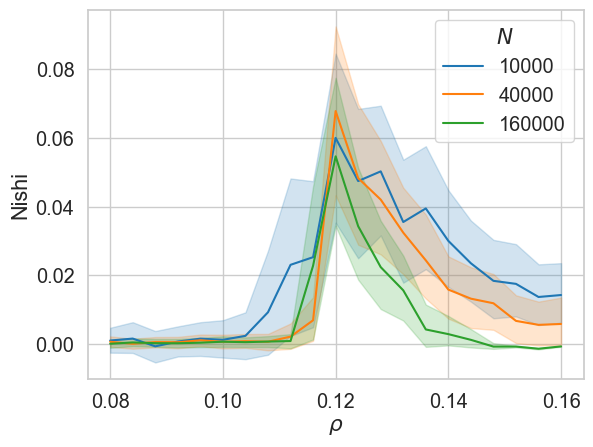

In [1296]:
sns.set_theme(style="whitegrid",font_scale=1.3)
data_frame_tot["Nishi"] = -data_frame_tot["$\delta O_{t=0}$"] #$\widetilde{\delta O}_{t=0}$
y_s = "$\delta {\rm O}_{t=0}$"
sns.lineplot(data=data_frame_tot,x=r"$\rho$",y="Nishi",hue=r"$N$",errorbar="ci", palette="tab10")

In [1297]:
sns.color_palette("dark:salmon_r",10)

[(0.9803921568627451, 0.5019607843137255, 0.4470588235294118),
 (0.8926754107797664, 0.4619320728962035, 0.4126885836234677),
 (0.8049586646967879, 0.42190336147868157, 0.37831834371752365),
 (0.7141091776822743, 0.3804450532248196, 0.3427205952435102),
 (0.6263924315992957, 0.34041634180729763, 0.3083503553375661),
 (0.5355429445847821, 0.29895803355343553, 0.27275260686355257),
 (0.4478261985018035, 0.25892932213591363, 0.23838236695760853),
 (0.35697671148728993, 0.2174710138820516, 0.20278461848359502),
 (0.2692599654043113, 0.17744230246452963, 0.16841437857765096),
 (0.18154321932133266, 0.1374135910470077, 0.13404413867170692)]

In [1298]:
# create a new dataframe as an extended copy data_frame_tot with a new column "Overlap", of double the length. the first half should be a copy of data_frame_tot and have r"$\widetilde{MO}_{t=0}$" stored in the new column, while the second half should be a copy of data_frame_tot and have r"$\widetilde{O}_{t=0}$" stored in the new column
data_frame_A = data_frame_tot.copy()    
data_frame_B = data_frame_tot.copy()
data_frame_A["O"] = data_frame_A[r"$\widetilde{MO}_{t=0}$"]
data_frame_B["O"] = data_frame_B[r"$\widetilde{O}_{t=0}$"]
data_frame_A["Overlap"] = r"$\widetilde{MO}_{t=0}$"
data_frame_B["Overlap"] = r"$\widetilde{O}_{t=0}$"
data_frame_tot_2 = pd.concat([data_frame_A, data_frame_B], ignore_index=True)


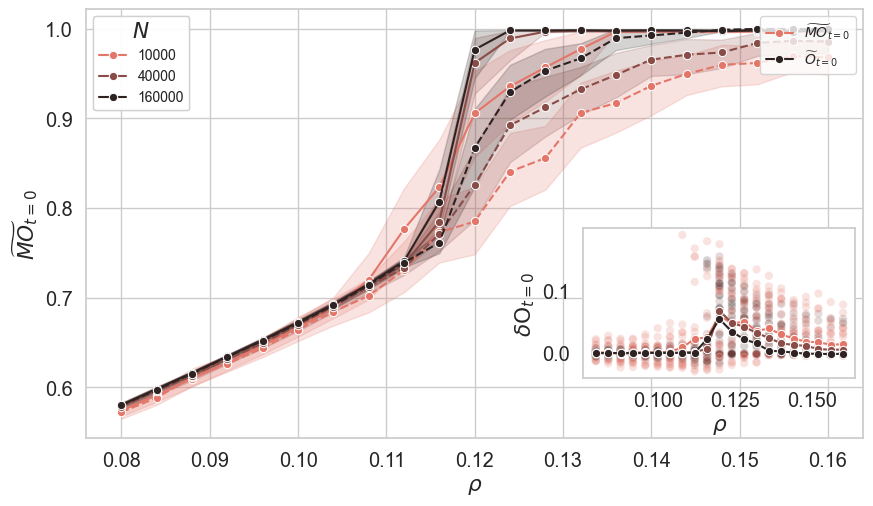

In [1302]:
# put the last plot as a inset of the previous one
palette = [sns.color_palette("dark:salmon_r",10)[1],sns.color_palette("dark:salmon_r",10)[5],sns.color_palette("dark:salmon_r",10)[9]]
fig, ax = plt.subplots(figsize=(9, 6))
y_s = "$\widetilde{MO}_{t=0}$"
sns.lineplot(data=data_frame_tot,x=r"$\rho$",y=y_s, hue=r"$N$",ax=ax,palette=palette,linestyle="solid",errorbar="ci",marker="o")
y_s = "$\widetilde{O}_{t=0}$"
sns.lineplot(data=data_frame_tot,x=r"$\rho$",y=y_s, hue=r"$N$", linestyle="--",legend=False,ax=ax,palette=palette,marker="o",errorbar="ci")
#axins in bottom right corner
axins = ax.inset_axes([0.64, 0.14, 0.35, 0.35])  # [x, y, width, height]
sns.lineplot(data=data_frame_tot,x=r"$\rho$",y="Nishi",hue=r"$N$",errorbar=None,ax=axins,legend=False,palette=palette,marker="o")
sns.scatterplot(data=data_frame_tot,x=r"$\rho$",y="Nishi",hue=r"$N$",ax=axins,legend=False,palette=palette,marker="o",alpha=0.2)
#axins.set_xlabel(r"$\rho$")
axins.set_ylabel(r"$\delta {\rm O}_{t=0}$")
axins.grid(False)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\widetilde{MO}_{t=0}$")
ax.legend(title=r"$N$", loc='upper left')

#add second legend to distinguish O vs MO 
handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[2]]
labels = [r"$\widetilde{MO}_{t=0}$", r"$\widetilde{O}_{t=0}$"]
legend2 = ax.legend(handles, labels, loc='upper right', fontsize=10)
ax.add_artist(ax.legend(title=r"$N$", loc='upper left', fontsize=10))

ax.add_artist(legend2)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

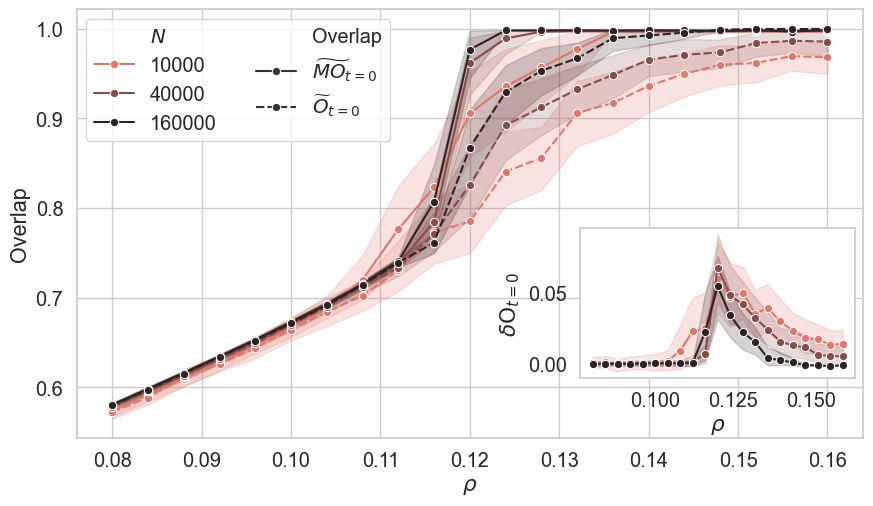

In [1240]:
# put the last plot as a inset of the previous one
palette = [sns.color_palette("dark:salmon_r",10)[1],sns.color_palette("dark:salmon_r",10)[5],sns.color_palette("dark:salmon_r",10)[9]]
fig, ax = plt.subplots(figsize=(9, 6))
y_s = "O"
sns.lineplot(data=data_frame_tot_2,x=r"$\rho$",y=y_s, hue=r"$N$",ax=ax,palette=palette,linestyle="solid",errorbar="ci",marker="o", style= "Overlap")
#axins in bottom right corner
axins = ax.inset_axes([0.64, 0.14, 0.35, 0.35])  # [x, y, width, height]
sns.lineplot(data=data_frame_tot,x=r"$\rho$",y="Nishi",hue=r"$N$",errorbar="ci",ax=axins,legend=False,palette=palette,marker="o")
#axins.set_xlabel(r"$\rho$")
axins.set_ylabel(r"$\delta {\rm O}_{t=0}$")
axins.grid(False)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"Overlap")

# Adjust legend
ax.legend(loc='upper left', ncol=2)

plt.tight_layout()
plt.subplots_adjust(top=0.85)

#plt.savefig("Nishimori_Rademacher.pdf")

In [1241]:
len(data_frame_tot[r"$\rho$"].unique())*5*20

2100

In [1242]:
data_frame_tot[r"$\rho$"].unique()
#order the data frame by rho
data_frame_tot.sort_values(r"$\rho$")

,init,graph_type,$N$,$d$,$\lambda$,s_type,S,o_type,M,iter_space,...,$\delta SE$,$R_{SE}$,$R_{MSE}$,$\delta R_{SE}$,ConvChecks,free_entropy_BP,free_entropy_AMP,total_free_entropy,$\rho$,Nishi
5088,rnd,rrg,40000,3,1.0,delta,0.5,rho,0.08,100,...,0.002592,0.418167,0.418533,-0.000366,"[[10, 0.001458395118840286, 4.1619720439480677...",NaN,NaN,NaN,0.08,-0.001736
1030,rnd,rrg,10000,3,1.0,delta,0.5,rho,0.08,100,...,0.011972,0.396304,0.426685,-0.030381,"[[10, 0.0006656048036629836, 4.086655747872499...",NaN,NaN,NaN,0.08,0.013820
223,rnd,rrg,40000,3,1.0,delta,0.5,rho,0.08,100,...,-0.005151,0.412890,0.407414,0.005477,"[[10, 0.0007390118011894251, 2.291445535381487...",NaN,NaN,NaN,0.08,-0.002585
4769,rnd,rrg,160000,3,1.0,delta,0.5,rho,0.08,100,...,-0.000826,0.412302,0.409093,0.003209,"[[10, 0.0013939231099781846, 3.913891946954977...",0.623149,-0.683033,-0.059883,0.08,-0.001461
1377,rnd,rrg,160000,3,1.0,delta,0.5,rho,0.08,100,...,0.000482,0.410720,0.410878,-0.000158,"[[10, 0.0016254393138268874, 3.850094573954838...",0.623250,-0.683087,-0.059837,0.08,-0.001352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4907,rnd,rrg,40000,3,1.0,delta,0.5,rho,0.16,100,...,-0.000714,0.999229,0.997289,0.001940,"[[9, 0.06849865441164094, 1.1803964903656835e-...",NaN,NaN,NaN,0.16,-0.000780
4583,rnd,rrg,40000,3,1.0,delta,0.5,rho,0.16,100,...,-0.000353,0.999457,0.998514,0.000943,"[[9, 0.0224702593908519, 6.036979173381491e-08]]",NaN,NaN,NaN,0.16,-0.000434
5190,rnd,rrg,40000,3,1.0,delta,0.5,rho,0.16,100,...,-0.001101,0.998386,0.995473,0.002913,"[[9, 0.04189619206309414, 1.7198727590040696e-...",NaN,NaN,NaN,0.16,-0.001130
864,rnd,rrg,40000,3,1.0,delta,0.5,rho,0.16,100,...,-0.001181,0.997668,0.994451,0.003216,"[[9, 0.034412626113288214, 6.254995055145842e-...",NaN,NaN,NaN,0.16,-0.001542


In [1243]:
data_frame_tot[r"$\rho$"].unique()

array([0.116, 0.08 , 0.112, 0.124, 0.12 , 0.108, 0.136, 0.16 , 0.128,
       0.084, 0.132, 0.092, 0.104, 0.096, 0.148, 0.152, 0.088, 0.14 ,
       0.144, 0.1  , 0.156])

# logZ + zoom

### c = 0

In [1244]:
# select data from data_frame_tot in such a way that MO - O is smaller than 0.1
df = data_frame_tot[(data_frame_tot[r"$\widetilde{MO}_{t=0}$"] - data_frame_tot[r"$\widetilde{O}_{t=0}$"]) <0.003]
df2 = data_frame_tot[(data_frame_tot[r"$\widetilde{MO}_{t=0}$"] - data_frame_tot[r"$\widetilde{O}_{t=0}$"]) <0.1]
len(df)
dfc0 = df

Text(0, 0.5, '$\\frac{1}{N}\\log Z$')

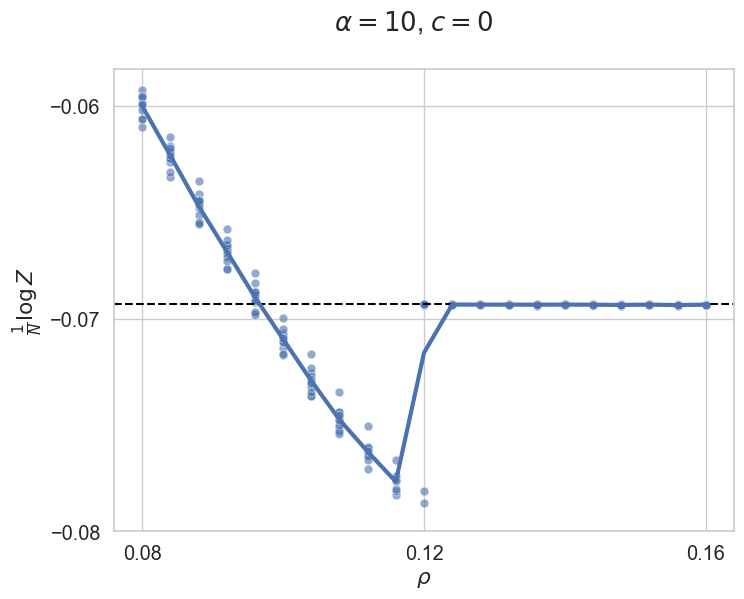

In [1214]:
#plot of logZ vs rho
fig, ax = plt.subplots( figsize=(8, 6))
fig.suptitle(r'$\alpha=10$, $c=0$')
y_s = r"$\log Z$"
sns.set_theme(style="whitegrid",font_scale=1.3)
y_s = "total_free_entropy"
ax.axhline(-np.log(2)/10, color='black', linestyle='--')
sns.scatterplot(data=df[df[r"$N$"]==160000],x=r"$\rho$",y=y_s, alpha=0.6,ax=ax, s=40)
sns.lineplot(data=df[df[r"$N$"]==160000],x=r"$\rho$",y=y_s, ax=ax, errorbar=None, linewidth=3)
ax.set_xticks([0.08, 0.12 , 0.16])
ax.set_yticks([-0.06, -0.07, -0.08])
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\frac{1}{N}\log Z$")
#fig.savefig("logZ_c0_alpha10.png", dpi=300)

Text(0, 0.5, '$\\widetilde{O}_{t=0}$')

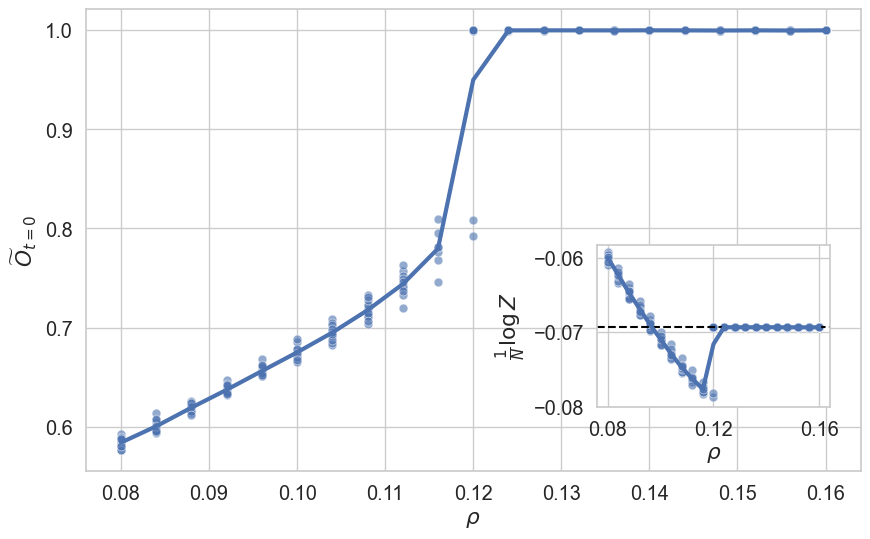

In [ ]:
fig, ax = plt.subplots( figsize=(10, 6))
y_s = "$\widetilde{O}_{t=0}$"
sns.lineplot(data=df[df[r"$N$"]==160000],x=r"$\rho$",y=y_s, errorbar=None, linewidth=3, ax=ax)
sns.scatterplot(data=df[df[r"$N$"]==160000],x=r"$\rho$",y=y_s, alpha=0.6, s=40, ax=ax)
#plot of logZ vs rho as inset
axins = ax.inset_axes([0.66, 0.14, 0.3, 0.35])  # [x, y, width, height]
axins.axhline(-np.log(2)/10, color='black', linestyle='--')
sns.lineplot(data=df[df[r"$N$"]==160000],x=r"$\rho$",y="total_free_entropy", ax=axins, errorbar=None, linewidth=3)
sns.scatterplot(data=df[df[r"$N$"]==160000],x=r"$\rho$",y="total_free_entropy", alpha=0.6, s=40, ax=axins)
axins.set_xlabel(r"$\rho$")
axins.set_ylabel(r"$\frac{1}{N}\log Z$")
axins.set_xticks([0.08, 0.12 , 0.16])
axins.set_yticks([-0.06, -0.07, -0.08])
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\widetilde{O}_{t=0}$")

fig.savefig("zoom_c0_alpha10.pdf")

### c = 1

In [384]:
load_Dir = "./CLUSTER/DataCxtEpi/data_zoom/"

In [385]:
#file_name = "DF_20250217-c0_a2.xz"
file_name = "DF_20250521-110942_253.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame_tot = pickle.load(f)
data_frame_tot[r"$\rho$"] = data_frame_tot["M"]

In [386]:
# select data from data_frame_tot in such a way that MO - O is smaller than 0.1
df = data_frame_tot[(data_frame_tot[r"$\widetilde{MO}_{t=0}$"] - data_frame_tot[r"$\widetilde{O}_{t=0}$"]) <0.007]
df2 = data_frame_tot[(data_frame_tot[r"$\widetilde{MO}_{t=0}$"] - data_frame_tot[r"$\widetilde{O}_{t=0}$"]) <0.1]
len(df)

462

Text(0, 0.5, '$\\frac{1}{N}\\log Z$')

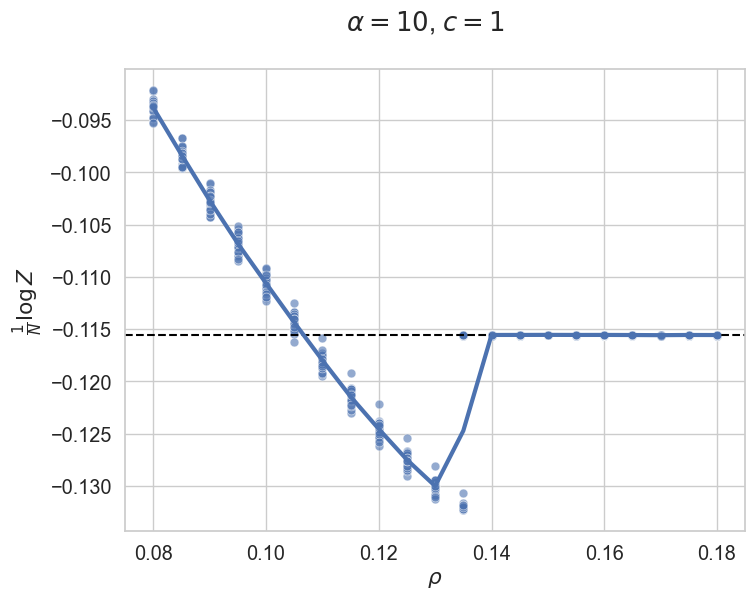

In [387]:
#plot of logZ vs rho
fig, ax = plt.subplots( figsize=(8, 6))
fig.suptitle(r'$\alpha=10$, $c=1$')
y_s = r"$\log Z$"
sns.set_theme(style="whitegrid",font_scale=1.3)
y_s = "total_free_entropy"
ax.axhline(-np.log(2)/6, color='black', linestyle='--')
sns.scatterplot(data=df,x=r"$\rho$",y=y_s, alpha=0.6,ax=ax, s=40)
sns.lineplot(data=df,x=r"$\rho$",y=y_s, ax=ax, errorbar=None, linewidth=3)
#ax.set_xticks([0.08, 0.12 , 0.16])
#ax.set_yticks([-0.06, -0.07, -0.08])
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\frac{1}{N}\log Z$")
#fig.savefig("logZ_c0_alpha10.png", dpi=300)

Text(0, 0.5, '$\\widetilde{O}_{t=0}$')

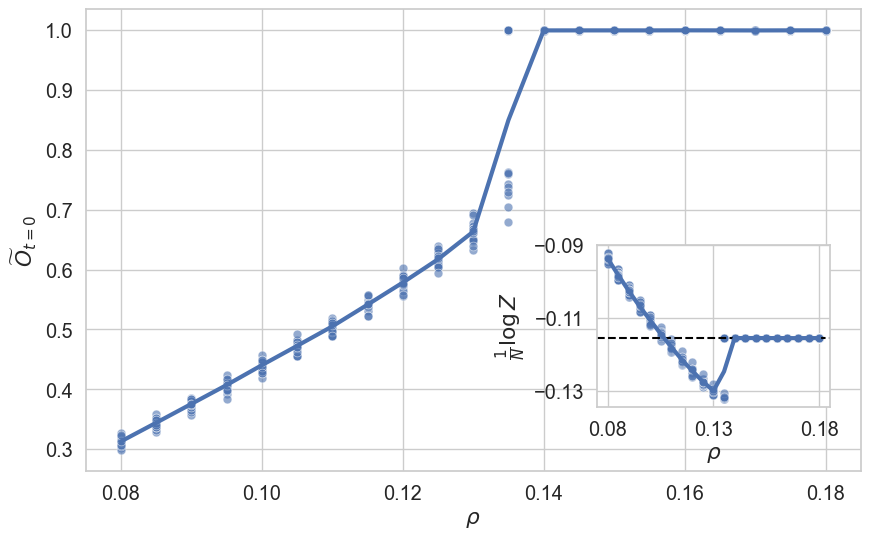

In [388]:
fig, ax = plt.subplots( figsize=(10, 6))
y_s = "$\widetilde{O}_{t=0}$"
sns.lineplot(data=df[df[r"$N$"]==120000],x=r"$\rho$",y=y_s, errorbar=None, linewidth=3, ax=ax)
sns.scatterplot(data=df[df[r"$N$"]==120000],x=r"$\rho$",y=y_s, alpha=0.6, s=40, ax=ax)
#plot of logZ vs rho as inset
axins = ax.inset_axes([0.66, 0.14, 0.3, 0.35])  # [x, y, width, height]
axins.axhline(-np.log(2)/6, color='black', linestyle='--')
sns.lineplot(data=df[df[r"$N$"]==120000],x=r"$\rho$",y="total_free_entropy", ax=axins, errorbar=None, linewidth=3)
sns.scatterplot(data=df[df[r"$N$"]==120000],x=r"$\rho$",y="total_free_entropy", alpha=0.6, s=40, ax=axins)
axins.set_xlabel(r"$\rho$")
axins.set_ylabel(r"$\frac{1}{N}\log Z$")
axins.set_xticks([0.08, 0.13 , 0.18])
axins.set_yticks([-0.09, -0.11, -0.13])
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\widetilde{O}_{t=0}$")

#fig.savefig("zoom_c0_alpha10.pdf")

### c = 2

In [400]:
# df2 taken from below
df2.head()

,init,graph_type,$N$,$d$,$\lambda$,s_type,S,o_type,M,iter_space,...,$MSE_{RND}$,$\delta SE$,$R_{SE}$,$R_{MSE}$,$\delta R_{SE}$,ConvChecks,free_entropy_BP,free_entropy_AMP,total_free_entropy,$\rho$
4,rnd,rrg,500000,3,1.0,delta,0.5,rho,0.00700,100,...,2.307212,-0.028547,0.992863,0.980491,0.012372,"[[10, 0.09029618815452561, 5.990354506601538e-...",0.557771,-0.564714,-0.006943,0.00700
7,rnd,rrg,500000,3,1.0,delta,0.5,rho,0.00575,100,...,2.317295,-0.005842,0.998609,0.996088,0.002521,"[[10, 0.00772041746745028, 9.8507514066952e-07...",0.582772,-0.589704,-0.006932,0.00575
17,rnd,rrg,500000,3,1.0,delta,0.5,rho,0.00350,100,...,2.310981,-0.008369,0.107789,0.105656,0.002133,"[[10, 0.0027838157554144205, 8.66778464586414e...",0.648574,-0.654673,-0.006100,0.00350
37,rnd,rrg,500000,3,1.0,delta,0.5,rho,0.00675,100,...,2.315553,-0.004335,0.998892,0.997020,0.001872,"[[10, 0.06644355043841366, 9.1966443746352e-07...",0.558744,-0.565677,-0.006932,0.00675
41,rnd,rrg,500000,3,1.0,delta,0.5,rho,0.00550,100,...,2.315956,1.996367,0.127885,0.990016,-0.862131,"[[10, 0.012983650511123712, 8.810546403084601e...",0.687138,-0.658262,0.028876,0.00550


In [404]:
# select data from df2 in such a way that MO - O is smaller than 0.1
l = len(df2)
df2 = df2[(df2[r"$\widetilde{MO}_{t=0}$"] - df2[r"$\widetilde{O}_{t=0}$"]) <0.0001]
(l-len(df2))/l

0.38345864661654133

Text(0, 0.5, '$\\frac{1}{N}\\log Z$')

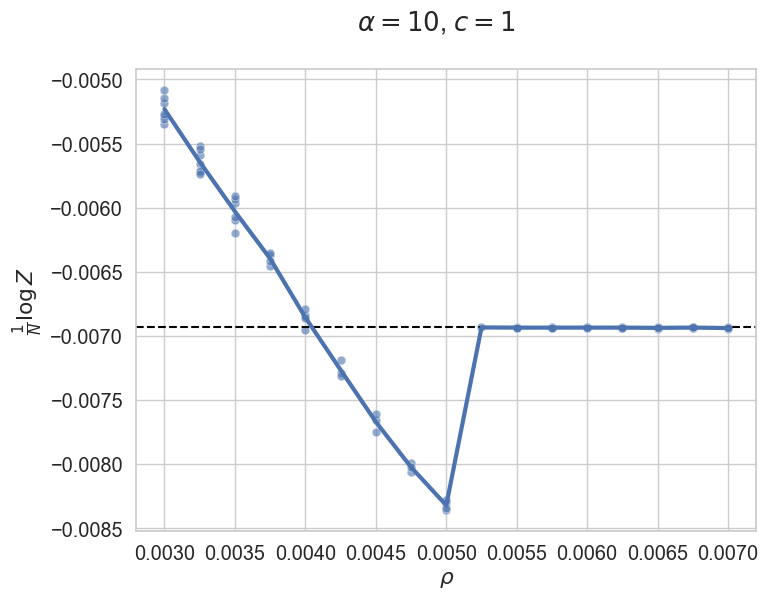

In [407]:
#plot of logZ vs rho
fig, ax = plt.subplots( figsize=(8, 6))
fig.suptitle(r'$\alpha=10$, $c=1$')
y_s = r"$\log Z$"
sns.set_theme(style="whitegrid",font_scale=1.3)
y_s = "total_free_entropy"
ax.axhline(-np.log(2)/100, color='black', linestyle='--')
sns.scatterplot(data=df2,x=r"$\rho$",y=y_s, alpha=0.6,ax=ax, s=40)
sns.lineplot(data=df2,x=r"$\rho$",y=y_s, ax=ax, errorbar=None, linewidth=3)
#ax.set_xticks([0.08, 0.12 , 0.16])
#ax.set_yticks([-0.06, -0.07, -0.08])
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\frac{1}{N}\log Z$")
#fig.savefig("logZ_c0_alpha10.png", dpi=300)

Text(0, 0.5, '$\\widetilde{O}_{t=0}$')

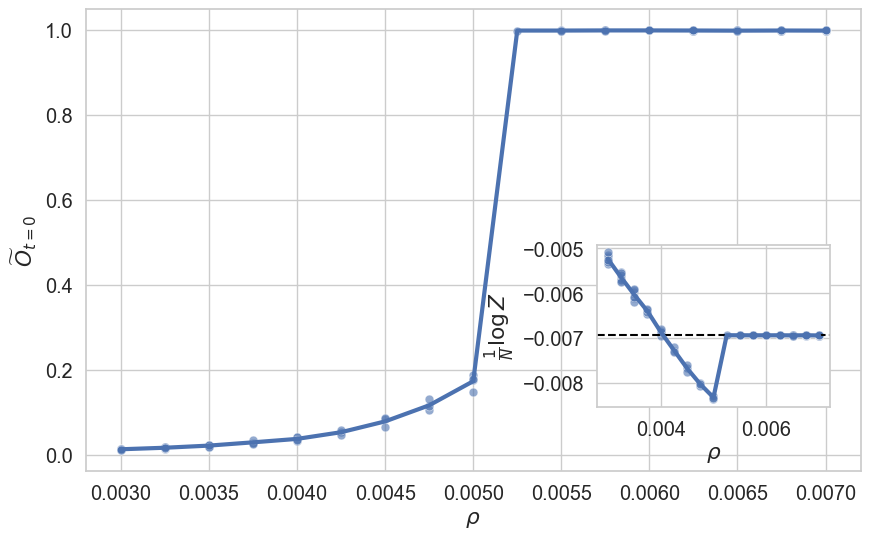

In [409]:
fig, ax = plt.subplots( figsize=(10, 6))
y_s = "$\widetilde{O}_{t=0}$"
sns.lineplot(data=df2,x=r"$\rho$",y=y_s, errorbar=None, linewidth=3, ax=ax)
sns.scatterplot(data=df2,x=r"$\rho$",y=y_s, alpha=0.6, s=40, ax=ax)
#plot of logZ vs rho as inset
axins = ax.inset_axes([0.66, 0.14, 0.3, 0.35])  # [x, y, width, height]
axins.axhline(-np.log(2)/100, color='black', linestyle='--')
sns.lineplot(data=df2,x=r"$\rho$",y="total_free_entropy", ax=axins, errorbar=None, linewidth=3)
sns.scatterplot(data=df2,x=r"$\rho$",y="total_free_entropy", alpha=0.6, s=40, ax=axins)
axins.set_xlabel(r"$\rho$")
axins.set_ylabel(r"$\frac{1}{N}\log Z$")
#axins.set_xticks([0.08, 0.13 , 0.18])
#axins.set_yticks([-0.09, -0.11, -0.13])
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\widetilde{O}_{t=0}$")

#fig.savefig("zoom_c0_alpha10.pdf")

### Together

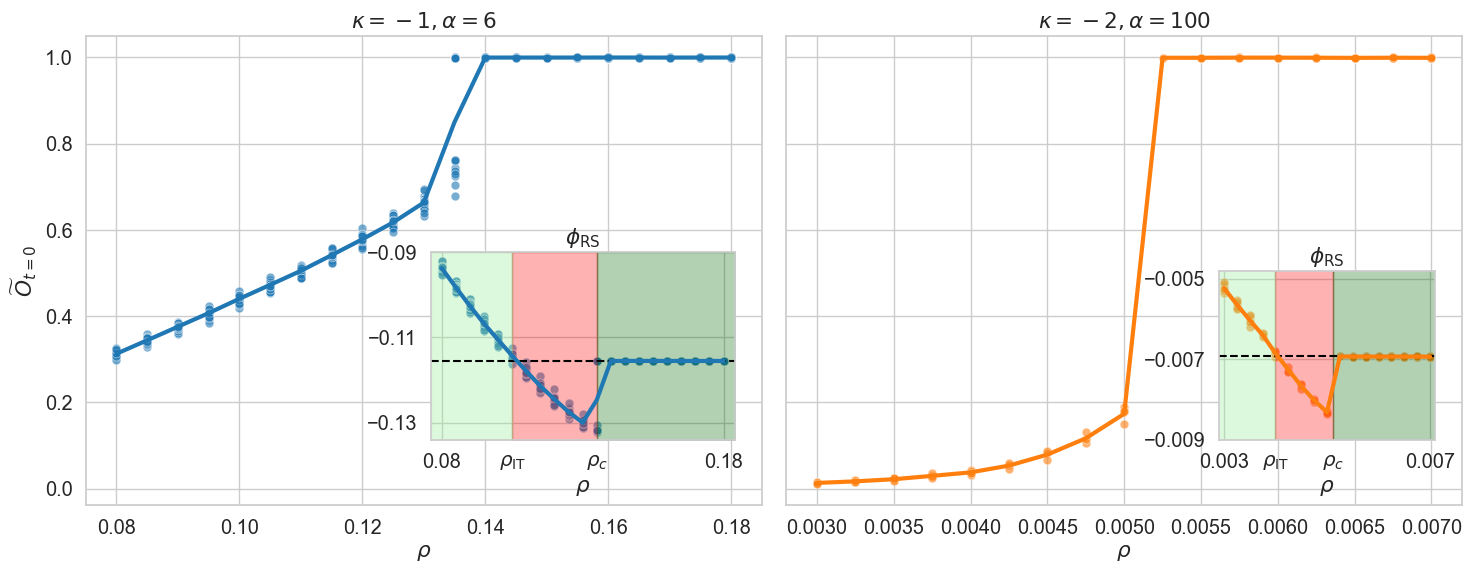

In [442]:
# Put the last plots for c=0 and c=1 in the same figure, side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
#fig.suptitle(r'$\alpha=10$')
y_s = r"$\widetilde{O}_{t=0}$"
axs[1].set_title(r'$\kappa=-2, \alpha=100$')
sns.lineplot(data=df2,x=r"$\rho$",y=y_s, errorbar=None, linewidth=3, ax=axs[1],color="tab:orange")
sns.scatterplot(data=df2,x=r"$\rho$",y=y_s, alpha=0.6, s=40, ax=axs[1],color="tab:orange")
#plot of logZ vs rho as inset
axins = axs[1].inset_axes([0.64, 0.14, 0.32, 0.36])  # [x, y, width, height]
axins.axhline(-np.log(2)/100, color='black', linestyle='--')
sns.lineplot(data=df2,x=r"$\rho$",y="total_free_entropy", ax=axins, errorbar=None, linewidth=3,color="tab:orange")
sns.scatterplot(data=df2,x=r"$\rho$",y="total_free_entropy", alpha=0.6, s=40, ax=axins,color="tab:orange")
x = [0.004,0.005125]
y = [0,-1]
axins.fill_between(x, y[0], y[1], color='red', alpha=0.3)
x = [0.,0.004]
y = [0,-1]
axins.fill_between(x, y[0], y[1], color='lightgreen', alpha=0.3)
x = [0.005125,1.]
y = [0,-1]
axins.fill_between(x, y[0], y[1], color='darkgreen', alpha=0.3)
axins.set_xlabel(r"$\rho$")
axins.set_ylabel("")
axins.set_title(r"$\phi_{\rm RS}$")
axins.set_xticks([0.003, 0.004, 0.005125 , 0.007])
axins.set_xticklabels([0.003, r"$\rho_{\rm IT}$", r"$\rho_{c}$", 0.007])
axins.set_yticks([-0.005, -0.007, -0.009])
axins.set_xlim(0.0029,0.0071)
axins.set_ylim(-0.009,-0.0048)
axs[1].set_xlabel(r"$\rho$")
axs[1].set_ylabel(r"$\widetilde{O}_{t=0}$")
#plot of overlap vs rho
axs[0].set_title(r'$\kappa=-1, \alpha=6$')
sns.lineplot(data=df[df[r"$N$"]==120000],x=r"$\rho$",y=y_s, errorbar=None, linewidth=3, ax=axs[0],color="tab:blue")
sns.scatterplot(data=df[df[r"$N$"]==120000],x=r"$\rho$",y=y_s, alpha=0.6, s=40, ax=axs[0],color="tab:blue")
#plot of logZ vs rho as inset
axins = axs[0].inset_axes([0.51, 0.14, 0.45, 0.4])  # [x, y, width, height]
axins.axhline(-np.log(2)/6, color='black', linestyle='--')
sns.lineplot(data=df[df[r"$N$"]==120000],x=r"$\rho$",y="total_free_entropy", ax=axins, errorbar=None, linewidth=3,color="tab:blue")
sns.scatterplot(data=df[df[r"$N$"]==120000],x=r"$\rho$",y="total_free_entropy", alpha=0.6, s=40, ax=axins,color="tab:blue")
x = [0.105,0.135]
y = [-0.134,-0.09]
axins.fill_between(x, y[0], y[1], color='red', alpha=0.3)
x = [0.076,0.105]
y = [-0.134,-0.09]
axins.fill_between(x, y[0], y[1], color='lightgreen', alpha=0.3)
x = [0.135,0.184]
y = [-0.134,-0.09]
axins.fill_between(x, y[0], y[1], color='darkgreen', alpha=0.3)
axins.set_xlabel(r"$\rho$")
axins.set_ylabel("")
axins.set_title(r"$\phi_{\rm RS}$")
axins.set_xticks([0.08, 0.105, 0.135 , 0.18])
axins.set_xticklabels([0.08, r"$\rho_{\rm IT}$", r"$\rho_{c}$", 0.18])
axins.set_yticks([-0.09, -0.11, -0.13])
axins.set_xlim(0.076,0.184)
axins.set_ylim(-0.134,-0.09)
axs[0].set_xlabel(r"$\rho$")
axs[0].set_ylabel(r"$\widetilde{O}_{t=0}$")
fig.tight_layout()
fig.savefig("zoom_logZ.pdf")

# c = 2

In [5]:
load_Dir = "../Data/"

In [6]:
#file_name = "DF_20250217-c0_a2.xz"
file_name = "DF_20250702-081958_256.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame_tot = pickle.load(f)

In [7]:
#data_frame_tot.iloc[:,-10:]
data_frame_tot[r"$\rho$"] = data_frame_tot["M"]

In [8]:
#a_ll = np.concat((np.linspace(8.7,8.9, 5),np.linspace(9.1,10.3, 7),np.linspace(10.5,10.7, 5),np.linspace(10.9,12.7, 10)))
#a_ll = np.array([8.85,9.1,9.5,10,10.5,10.8, 11.1, 11.7, 12.3])
a_ll = np.logspace(0,2,19,base=10)[9:]
print(a_ll)
print(np.int64(10000*np.sqrt(a_ll)/2)*2)
print(np.int64(10000/np.sqrt(a_ll)))
#,np.linspace(8.95,12.75, 20)

[ 10.          12.91549665  16.68100537  21.5443469   27.82559402
  35.93813664  46.41588834  59.94842503  77.42636827 100.        ]
[ 31622  35938  40842  46414  52748  59948  68128  77426  87992 100000]
[3162 2782 2448 2154 1895 1668 1467 1291 1136 1000]


#### Single

In [9]:
i = 10
#print(int(10000*a_ll[i]**0.5),a_ll[i])

In [10]:
a_ll = np.logspace(0,2,19,base=10)
np.logspace(np.log10(8.6),np.log10(10),4,base=10)

array([ 8.6       ,  9.04341167,  9.50968541, 10.        ])

( 120266 123352 134580 139140 ) (13304 12971 11889 11499)

In [11]:
print(np.int64(10000*np.sqrt(9.04)/2)*2,np.round(40000/(np.sqrt(9.04))).astype(int))

30066 13304


In [12]:
print(np.int64(40000*np.sqrt(9.51)/2)*2,np.round(40000/(np.sqrt(9.51))).astype(int))

123352 12971


In [13]:
print(np.int64(40000*np.sqrt(11.32)/2)*2,np.round(40000/(np.sqrt(11.32))).astype(int))

134580 11889


In [14]:
print(np.int64(40000*np.sqrt(12.1)/2)*2,np.round(40000/(np.sqrt(12.1))).astype(int))

139140 11499


In [15]:
#N_tab = (np.ceil(np.sqrt(a_ll[9:])*50000/2.)*2.).astype(int)
N_tab = np.int64(40000*np.sqrt(a_ll[9:])/2)*2
M_tab = np.round(40000/(np.sqrt(a_ll[9:]))).astype(int)
print(N_tab)
print(M_tab)

[126490 143752 163368 185662 210998 239792 272516 309704 351968 400000]
[12649 11130  9794  8618  7583  6672  5871  5166  4546  4000]


In [22]:
N_tab = [120266, 123352, 134580, 139140]
M_tab = [13304, 12971, 11889, 11499]
i = 12
N = N_tab[i-9]
M = M_tab[i-9]

IndexError: list index out of range

In [23]:
N = 400000
M = 4000

In [24]:
aaa = N/M
print(N,M)

400000 4000


In [25]:
aaa

100.0

In [26]:
#aaa = 12.3
#N = int(50000*np.sqrt(aaa)/2)*2
#M = int(50000/np.sqrt(aaa))
#
data_frame_tot[data_frame_tot[r"$N$"]==(N)][r"$\rho$"].unique()

array([0.014, 0.012, 0.019, 0.018, 0.016, 0.011, 0.02 , 0.015, 0.01 ,
       0.013, 0.017])

In [2266]:
df2 = data_frame_tot[data_frame_tot[r"$N$"] == N]
#df = df2[abs((df2[r"$O_{t=0}$"] - df2[r"$MO_{t=0}$"])) < 0.001]
#df = df2[df2[r"total_free_entropy"]>-0.3]
#(len(df2)- len(df)) / len(df2)

In [2267]:
l = len(df2)
print(l)
i=0
while (i < l-1):
    dict = {}
    dict[r"$\rho$"] = df2.iloc[i][r"$\rho$"]
    dict[r"delta_free_entropy"] = df2.iloc[i][r"total_free_entropy"] - df2.iloc[i+1][r"total_free_entropy"]
    dict["delta_O"] = df2.iloc[i][r"$O_{t=0}$"] - df2.iloc[i][r"$MO_{t=0}$"]
    dict[r"$\widetilde{O}_{t=0}$"] = df2.iloc[i][r"$\widetilde{O}_{t=0}$"]
    

    if i == 0:
        df_diff = pd.DataFrame(dict, index=[0])
    else:
        pass
        df_diff = pd.concat([df_diff, pd.DataFrame(dict, index=[0])], ignore_index=True)
    i += 2

df_diff

260


,$\rho$,delta_free_entropy,delta_O,$\widetilde{O}_{t=0}$
0,0.25,-0.005137,0.000236,0.898294
1,0.33,-0.217649,-0.000948,0.954786
2,0.35,0.000005,0.000016,1.000000
3,0.29,-0.006073,0.000021,0.932267
4,0.37,-0.000005,0.000004,0.999682
...,...,...,...,...
125,0.37,-0.000019,0.000006,0.999683
126,0.17,0.000310,0.000174,0.735629
127,0.19,-0.002230,0.000280,0.808701
128,0.25,0.142332,-0.003876,0.824691


In [2268]:
df_diff_ = df_diff[(abs(df_diff["delta_O"]) < 0.003) & (abs(df_diff["delta_free_entropy"]) <0.01)]
len(df_diff_)

120

In [2269]:
df2.loc[:,r"$1-\widetilde{O}_{t=0}$"] = 1 - df2.loc[:,r"$\widetilde{O}_{t=0}$"]
df2.loc[:,r"$1-O_{t=0}$"] = 1 - df2.loc[:,r"$O_{t=0}$"]
df2.loc[:,r"$\alpha$"] = np.round(df2.loc[:,r"$N$"] / df2.loc[:,r"$M$"],2)

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_39037/3928700826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,r"$1-\widetilde{O}_{t=0}$"] = 1 - df2.loc[:,r"$\widetilde{O}_{t=0}$"]
/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_39037/3928700826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,r"$1-O_{t=0}$"] = 1 - df2.loc[:,r"$O_{t=0}$"]
/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_39037/3928700826.py:3: SettingWithCopyWarning: 
A value is tr

In [2270]:
df_rnd = df[df["init"]=="rnd"]
df_inf = df[df["init"]=="inf"]
len(df_rnd), len(df_inf)

(102, 110)

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_39037/1773046042.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax.axhline(0., color=plt.cm.get_cmap('tab10')(0), linestyle='--')


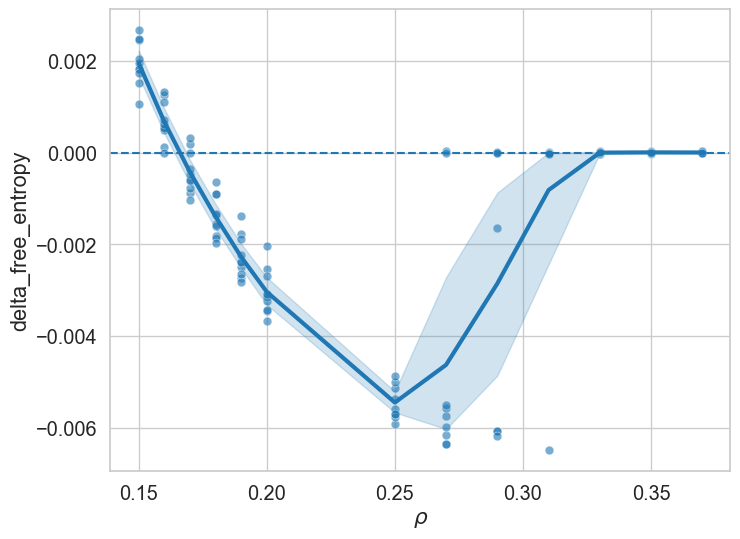

In [2271]:
dfZ = df2[df2[r"total_free_entropy"]>-5]
fig, ax = plt.subplots( figsize=(8, 6))
#fig.suptitle(r'$\kappa=2$, $N * M = 2.5 \times 10^9$, $\alpha=12.91$')
y_s = r"delta_free_entropy"#"total_free_entropy"
sns.scatterplot(data=df_diff_,x=r"$\rho$",y=y_s, alpha=0.6, s=40, ax=ax, legend=False, color="tab:blue")
sns.lineplot(data=df_diff_,x=r"$\rho$",y=y_s, errorbar="ci", linewidth=3, ax=ax, color="tab:blue")
#sns.scatterplot(data=df_inf,x=r"$\rho$",y=y_s, alpha=0.6, s=40, ax=ax, legend=False, color="tab:orange")
#sns.lineplot(data=df_inf,x=r"$\rho$",y=y_s, errorbar="ci", linewidth=3, ax=ax, color="tab:orange")



ax.axhline(0., color=plt.cm.get_cmap('tab10')(0), linestyle='--')
#ax.axhline(-np.log(2)/4, color=plt.cm.get_cmap('tab10')(1), linestyle='--')
#ax.axhline(-np.log(2)/8, color=plt.cm.get_cmap('tab10')(2), linestyle='--')
#ax.set_xlim(0.15, 0.25)

Text(0, 0.5, '$\\widetilde{O}_{t=0}$')

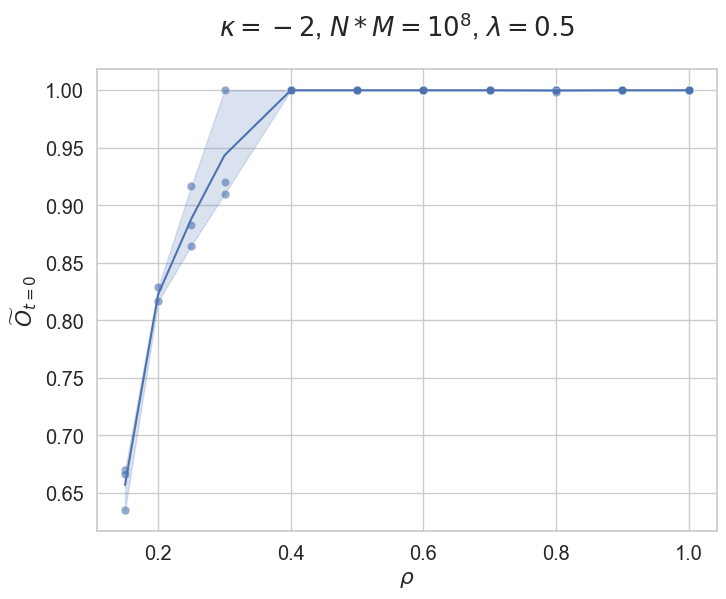

In [1967]:
fig, ax = plt.subplots( figsize=(8, 6))
fig.suptitle(r'$\kappa=-2$, $N * M =  10^8$, $\lambda=0.5$')
sns.lineplot(data=df_diff_,x=r"$\rho$",y=r"$\widetilde{O}_{t=0}$",errorbar="ci",legend=False,)
sns.scatterplot(data=df_diff_,x=r"$\rho$",y=r"$\widetilde{O}_{t=0}$", alpha=0.6, s=40, ax=ax,)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\widetilde{O}_{t=0}$")
#ax.set_yscale('log')#, linthresh=0.000001)
#fig.savefig("out.pdf")

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_39037/2918417161.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"$\widetilde{MO}_{t=0}$", hue=r"$N$",errorbar="ci", palette="tab10",ax=axs[0],legend=False)
/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_39037/2918417161.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"total_free_entropy", hue=r"$N$",errorbar="ci", palette="tab10",ax=axs[1],legend=False)
/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_39037/2918417161.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"total_free_entropy", hue=r"$N$",ax=axs[1],palette="tab10",marker="o",alpha=0.5)


(-0.1, 0.0)

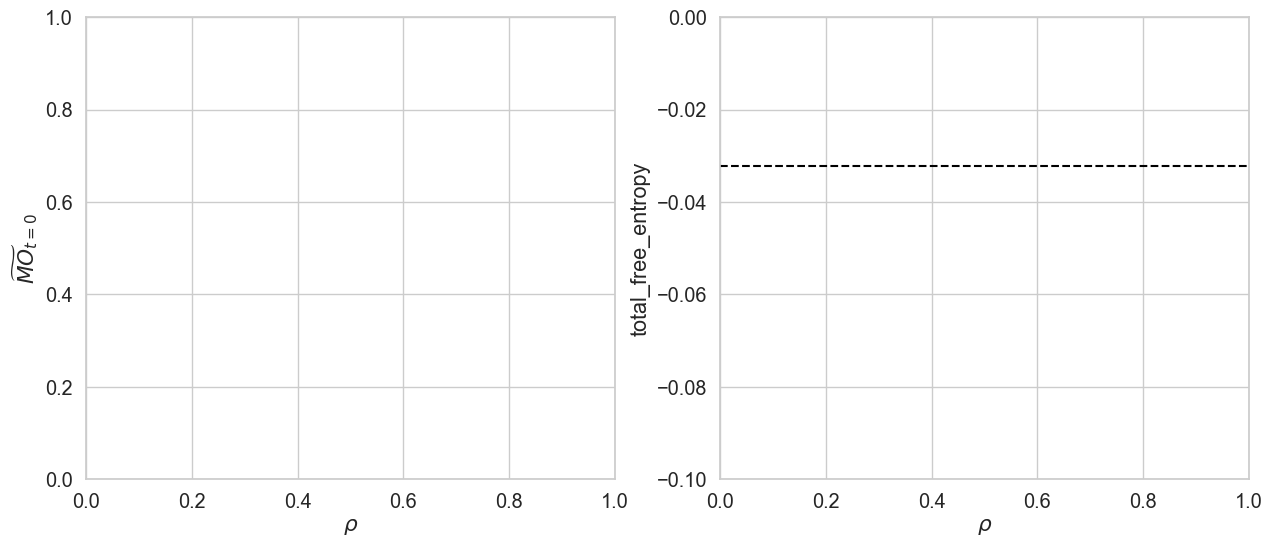

In [1817]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"$\widetilde{MO}_{t=0}$", hue=r"$N$",errorbar="ci", palette="tab10",ax=axs[0],legend=False)
sns.lineplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"total_free_entropy", hue=r"$N$",errorbar="ci", palette="tab10",ax=axs[1],legend=False)
sns.scatterplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"total_free_entropy", hue=r"$N$",ax=axs[1],palette="tab10",marker="o",alpha=0.5)
axs[1].axhline(-np.log(2)*M/N, color='black', linestyle='--')
axs[1].set_ylim(-0.1,0.)

In [370]:
sorted(data_frame_tot[data_frame_tot[r"$N$"]==N][r"$\rho$"].unique())

[0.003,
 0.00325,
 0.0035,
 0.00375,
 0.004,
 0.00425,
 0.0045,
 0.00475,
 0.005,
 0.00525,
 0.0055,
 0.00575,
 0.006,
 0.00625,
 0.0065,
 0.00675,
 0.007]

#### Together

In [714]:
np.logspace(0,2,19,base=10)[10:]

array([ 12.91549665,  16.68100537,  21.5443469 ,  27.82559402,
        35.93813664,  46.41588834,  59.94842503,  77.42636827,
       100.        ])

In [2272]:
#lambda=1
rho_cc_tab_2 = [1,0.2, 0.12, 0.086, 0.071] + [0.062, 0.038, 0.027, 0.02, 0.015, 0.0115, 0.00875, 0.00675, 0.005125 ]
rho_IT_tab_2 = [1,0.2, 0.14, 0.094, 0.077, 0.067, 0.062, 0.0575, 0.0519, 0.0469] + [0.043, 0.029, 0.021, 0.016, 0.01175, 0.009, 0.00675, 0.005125, 0.00405]
rho_sd_tab_2 = [0,0.05, 0.02, 0.007, 0.004]+ [0.004, 0.002, 0.001, 0.001, 0.0005, 0.0005, 0.0005, 0.00025, 0.00025]
rho_sd_IT_tab_2 = [0, 0.05, 0.025, 0.006, 0.004, 0.0025, 0.0025, 0.0016, 0.001, 0.001] + [0.004, 0.002, 0.001, 0.001, 0.0005, 0.0005, 0.0005, 0.00025, 0.00025]
al_tab_IT_2 = [8.6, 8.85, 9.1, 9.5, 10, 10.5, 10.8, 11.1, 11.7, 12.3] + [12.91549665,  16.68100537,  21.5443469 ,  27.82559402, 35.93813664,  46.41588834,  59.94842503,  77.42636827, 100.]
al_tab_2 = [10.6, 10.8, 11.1, 11.7, 12.3] + [12.91549665,  16.68100537,  21.5443469 ,  27.82559402, 35.93813664,  46.41588834,  59.94842503,  77.42636827, 100.]
#lambda=0.5
rho_cc_tab_2_l5 = [1, 0.45, 0.29 ,0.23, 0.1275, 0.0875, 0.062, 0.045, 0.03475, 0.026, 0.0205, 0.0155]
rho_IT_tab_2_l5 = [1, 0.64, 0.425, 0.305, 0.195 , 0.164, 0.1475, 0.095, 0.067, 0.048, 0.0365, 0.0275, 0.021, 0.016, 0.012]
rho_sd_tab_2_l5 = [0, 0.07 , 0.04 ,0.02, 0.005, 0.003, 0.002, 0.002, 0.0015, 0.001, 0.0001, 0.0001]
rho_sd_IT_tab_2_l5 = [0,0.05 ,0.04, 0.03, 0.015 , 0.009 ,0.0075, 0.004, 0.002, 0.0025, 0.0015, 0.001, 0.00075, 0.0005, 0.0005]
al_tab_IT_2_l5 = [8.6,9.04,9.51,10.,11.32, 12.1,  12.91549665,  16.68100537,  21.5443469 ,  27.82559402, 35.93813664,  46.41588834,  59.94842503,  77.42636827, 100.]
al_tab_2_l5 = [10.6,11.32,12.1, 12.91549665,  16.68100537,  21.5443469 ,  27.82559402, 35.93813664,  46.41588834,  59.94842503,  77.42636827, 100.]

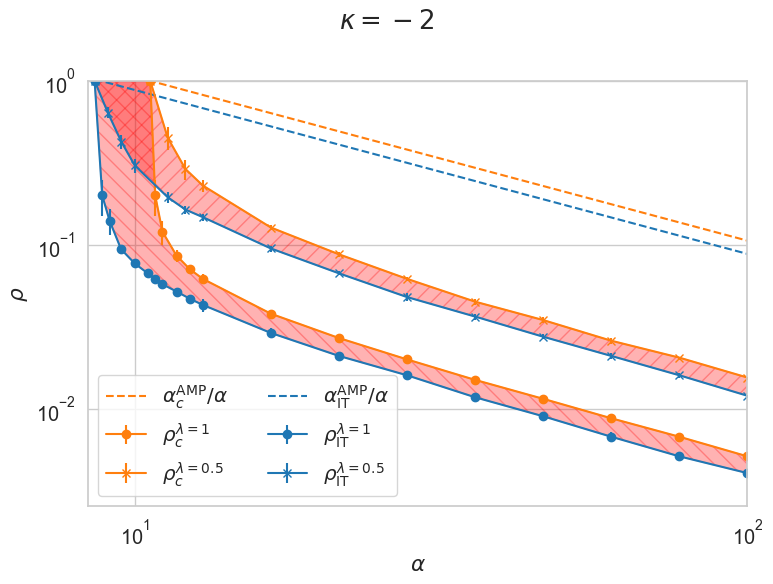

In [2273]:
sns.set_theme(style="whitegrid", font_scale=1.3)
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle(r'$\kappa=-2$')
ax.plot(np.linspace(1,100,1000),10.6/np.linspace(1,100,1000),'--',label=r'$\alpha_c^{\rm AMP}/\alpha$', color='tab:orange')
ax.errorbar(al_tab_2,rho_cc_tab_2,yerr=rho_sd_tab_2,fmt='o-',label=r'$\rho_c^{\lambda=1}$', color='tab:orange')
ax.errorbar(al_tab_2_l5,rho_cc_tab_2_l5,yerr=rho_sd_tab_2_l5,fmt='x-',label=r'$\rho_c^{\lambda=0.5}$', color='tab:orange')
ax.plot(np.linspace(1,100,1000),8.8/np.linspace(1,100,1000),'--',label=r'$\alpha_{\rm IT}^{\rm AMP}/\alpha$', color='tab:blue')
#lambda=1

ax.errorbar(al_tab_IT_2,rho_IT_tab_2,yerr=rho_sd_IT_tab_2,fmt='o-',label=r'$\rho_{\rm IT}^{\lambda=1}$', color='tab:blue')
#lambda=0.5

ax.errorbar(al_tab_IT_2_l5,rho_IT_tab_2_l5,yerr=rho_sd_IT_tab_2_l5,fmt='x-',label=r'$\rho_{\rm IT}^{\lambda=0.5}$', color='tab:blue')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\rho$')
ax.set_ylim(plt.ylim()[0], 1)
ax.set_xlim(8.4, 100)
#ax.axvline(7.9573, color='red', linestyle='--', label=r'$\alpha=\alpha_{\rm AMP}$')
handles, labels = ax.get_legend_handles_labels()
orders = [0, 2, 3, 1, 4, 5]
handles = [handles[i] for i in orders]
labels = [labels[i] for i in orders]
ax.legend(handles, labels,ncol=2, loc='lower left')
plt.tight_layout()

x_start = 8.6
x_end = 100

x1 = al_tab_2
y1 = rho_cc_tab_2

x2 = al_tab_IT_2
y2 = rho_IT_tab_2

y_start = 1#y1[0] if x_start == x1[0] else y2[0]
y1_end = y1[-1] if x_end == x1[-1] else y2[-1]
y2_end = y2[-1]# if x_end == x1[-1] else y2[-1]

# Ensure all points from x1 and x2 are included in the interpolation
x_combined = sorted(set(np.r_[x_start, x1, x2, x_end]))
y1_combined = np.interp(x_combined, np.r_[x_start, x1, x_end], np.r_[y_start, y1, y1_end])
y2_combined = np.interp(x_combined, np.r_[x_start, x2, x_end], np.r_[y_start, y2, y2_end])

# Add the last point explicitly to ensure it is included
x_combined.append(x_end)
y1_combined = np.append(y1_combined, y1[-1])
y2_combined = np.append(y2_combined, y2[-1])

# Fill the area between the two interpolated curves
plt.fill_between(x_combined, y1_combined, y2_combined, color="red", alpha=0.3, hatch='\\\\')

x1 = al_tab_2_l5
y1 = rho_cc_tab_2_l5

x2 = al_tab_IT_2_l5
y2 = rho_IT_tab_2_l5

y_start = 1#y1[0] if x_start == x1[0] else y2[0]
y1_end = y1[-1] if x_end == x1[-1] else y2[-1]
y2_end = y2[-1]# if x_end == x1[-1] else y2[-1]

# Ensure all points from x1 and x2 are included in the interpolation
x_combined = sorted(set(np.r_[x_start, x1, x2, x_end]))
y1_combined = np.interp(x_combined, np.r_[x_start, x1, x_end], np.r_[y_start, y1, y1_end])
y2_combined = np.interp(x_combined, np.r_[x_start, x2, x_end], np.r_[y_start, y2, y2_end])

# Add the last point explicitly to ensure it is included
x_combined.append(x_end)
y1_combined = np.append(y1_combined, y1[-1])
y2_combined = np.append(y2_combined, y2[-1])

# Fill the area between the two interpolated curves
plt.fill_between(x_combined, y1_combined, y2_combined, color="red", alpha=0.3, hatch='//')

fig.savefig('phase_diag_k2.png', dpi=400)

# c = 1

In [357]:
load_Dir = "./CLUSTER/DataCxtEpi/data_new/"

In [358]:
#file_name = "DF_20250217-c0_a2.xz"
file_name = "DF_20250621-c1critical.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame_tot = pickle.load(f)

In [359]:
#data_frame_tot.iloc[:,-10:]
data_frame_tot[r"$\rho$"] = data_frame_tot["M"]

In [360]:
print(a_ll)

[  1.           1.29154967   1.66810054   2.15443469   2.7825594
   3.59381366   4.64158883   5.9948425    7.74263683  10.
  12.91549665  16.68100537  21.5443469   27.82559402  35.93813664
  46.41588834  59.94842503  77.42636827 100.        ]


In [361]:
a_ll = np.logspace(0,2,19,base=10)
print(a_ll**0.5*50000)

[ 50000.          56823.18331929  64577.48325074  73389.9633811
  83405.02686     94786.78262032 107721.73450159 122421.83734111
 139127.97011036 158113.88300842 179690.68319023 204211.93263373
 232079.44168064 263749.85318513 299742.12515947 340646.03452898
 387131.84134056 439961.27178455 500000.        ]


#### Single

In [331]:
i = 5
print(int(50000*a_ll[i]**0.5),a_ll[i])

94786 3.5938136638046276


In [332]:
N_tab = (np.ceil(np.sqrt(a_ll[4:])*50000/2.)*2.).astype(int)
M_tab = np.round(50000/(np.sqrt(a_ll[4:]))).astype(int)
print(N_tab)

[ 83406  94788 107722 122422 139128 158114 179692 204212 232080 263750
 299744 340648 387132 439962 500000]


In [333]:
N = N_tab[i-4]
M = M_tab[i-4]

In [334]:
data_frame_tot[data_frame_tot[r"$N$"]==N][r"$\rho$"].unique()

array([0.2725, 0.19  , 0.2575, 0.2425, 0.2875, 0.265 , 0.18  , 0.2825,
       0.175 , 0.28  , 0.17  , 0.21  , 0.255 , 0.2475, 0.23  , 0.2   ,
       0.235 , 0.185 , 0.205 , 0.25  , 0.27  , 0.2675, 0.275 , 0.2775,
       0.215 , 0.22  , 0.285 , 0.24  , 0.29  , 0.245 , 0.195 , 0.2525,
       0.2625, 0.26  , 0.225 ])

In [335]:
df = data_frame_tot[(data_frame_tot[r"$\widetilde{MO}_{t=0}$"] - data_frame_tot[r"$\widetilde{O}_{t=0}$"]) <0.0005]
(len(data_frame_tot)- len(df))/ len(data_frame_tot)

0.40319715808170514

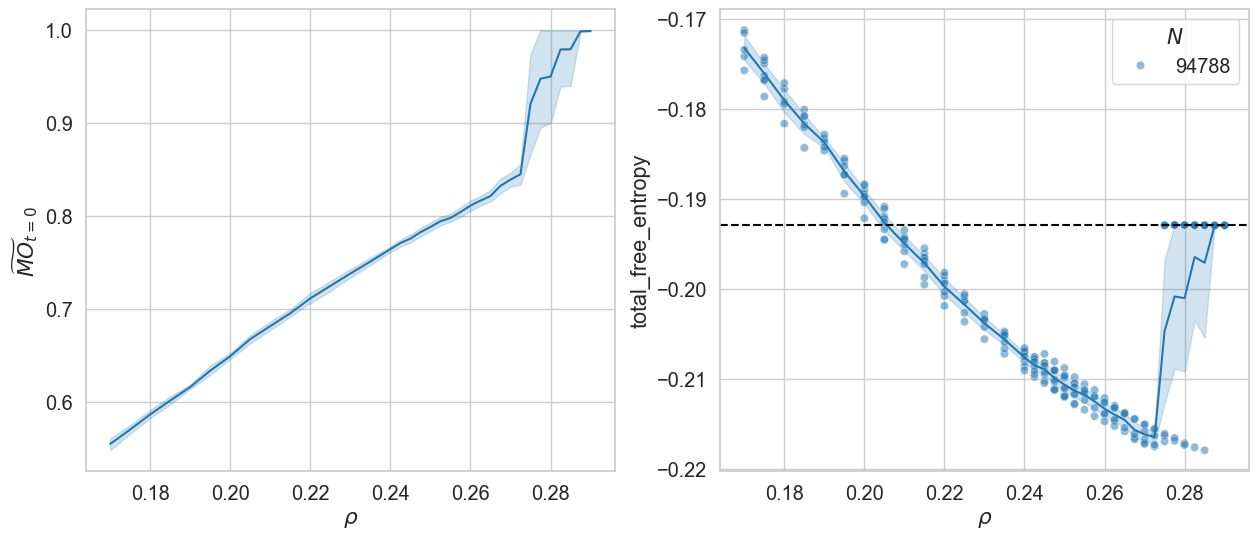

In [336]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"$\widetilde{MO}_{t=0}$", hue=r"$N$",errorbar="ci", palette="tab10",ax=axs[0],legend=False)
sns.lineplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"total_free_entropy", hue=r"$N$",errorbar="ci", palette="tab10",ax=axs[1],legend=False)
sns.scatterplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"total_free_entropy", hue=r"$N$",ax=axs[1],palette="tab10",marker="o",alpha=0.5)
axs[1].axhline(-np.log(2)*M/N, color='black', linestyle='--')

Slope: -0.5371837460820537, Intercept: -0.08207480557881111, R-squared: 0.998766139860127, P-value: 6.340686317121213e-13, Std Err: 0.006675425170561754


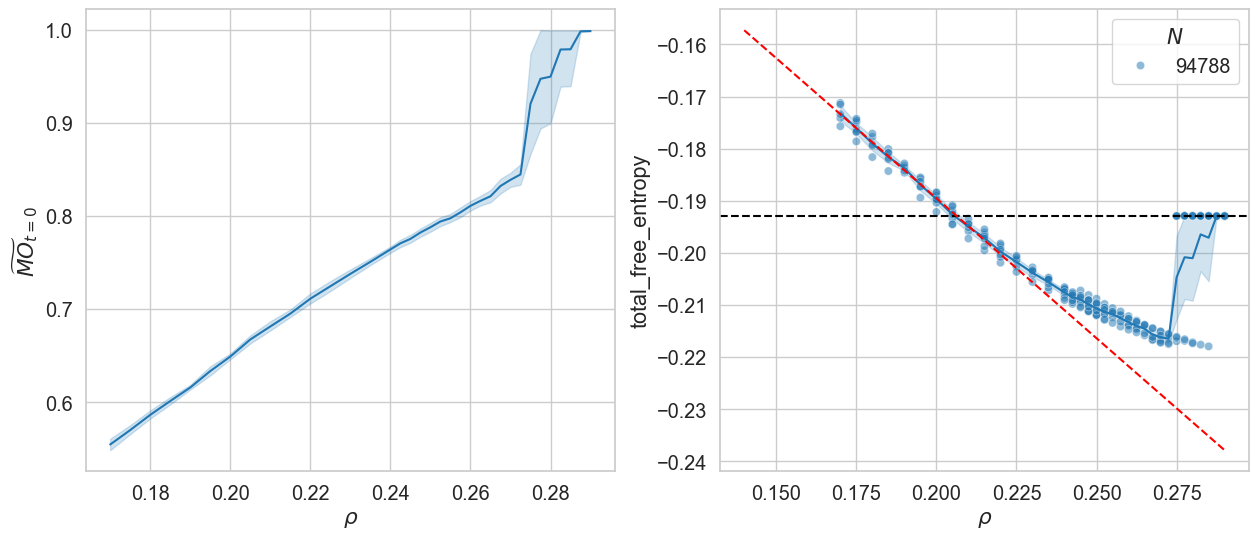

In [337]:
logZ = np.array(df[df[r"$N$"]==N].sort_values(by=r"$\rho$")["total_free_entropy"].groupby(df[r"$\rho$"]).mean())
rhos = sorted(df[df[r"$N$"]==N][r"$\rho$"].unique())
#do a linear fit to the data in logZ vs rho
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(rhos[0:10], logZ[0:10])
print(f"Slope: {slope}, Intercept: {intercept}, R-squared: {r_value**2}, P-value: {p_value}, Std Err: {std_err}")

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"$\widetilde{MO}_{t=0}$", hue=r"$N$",errorbar="ci", palette="tab10",ax=axs[0],legend=False)
sns.lineplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"total_free_entropy", hue=r"$N$",errorbar="ci", palette="tab10",ax=axs[1],legend=False)
sns.scatterplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"total_free_entropy", hue=r"$N$",ax=axs[1],palette="tab10",marker="o",alpha=0.5)
axs[1].axhline(-np.log(2)*M/N, color='black', linestyle='--')
#plot the linear fit to the data in logZ vs rho
x_fit = np.linspace(0.14, df[df[r"$N$"]==N][r"$\rho$"].max(), 100)
y_fit = slope * x_fit + intercept
axs[1].plot(x_fit, y_fit, color='red', linestyle='--', label='Linear Fit')

In [338]:
(-np.log(2)*M/N - intercept)/slope

np.float64(0.2062518568974144)

#### Together

In [362]:
rho_cc_tab_1 = [0.485,  0.28, 0.19, 0.137, 0.1, 0.075, 0.057, 0.044,
              0.033, 0.0255, 0.02, 0.01575, 0.0115, 0.009, 0.007]
rho_IT_tab_1 = [0.314, 0.2063, 0.1447, 0.106, 0.0792, 0.059, 0.0456, 0.0348,
              0.0266, 0.02036, 0.0156, 0.01217, 0.00933, 0.00717, 0.005585]
rho_sd_tab_1 = [0.01, 0.0075, 0.005, 0.004, 0.002, 0.001, 0.001, 0.002,
              0.001, 0.0012, 0.001, 0.00075, 0.0005, 0.0005, 0.00025]
al_tab_1 = a_ll[4:]

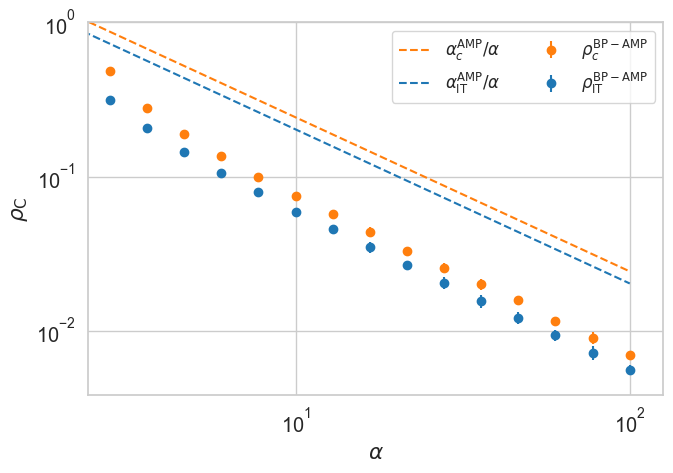

In [363]:
fig, ax = plt.subplots(figsize=(7, 5))
#fig.suptitle(r'$\rho_C(\alpha)$ for $\kappa=-1$')
ax.plot(np.linspace(1,100,1000),2.425/np.linspace(1,100,1000),'--',label=r'$\alpha_c^{\rm AMP} / \alpha$', color='tab:orange')
ax.errorbar(al_tab_1,rho_cc_tab_1,yerr=1.5*np.array(rho_sd_tab_1),fmt='o',label=r'$\rho_c^{\rm BP-AMP}$', color='tab:orange')
ax.plot(np.linspace(1,100,1000),2.025/np.linspace(1,100,1000),'--',label=r'$\alpha_{\rm IT}^{\rm AMP} / \alpha$', color='tab:blue')
ax.errorbar(al_tab_1,rho_IT_tab_1,yerr=1.5*np.array(rho_sd_tab_1),fmt='o',label=r'$\rho_{\rm IT}^{\rm BP-AMP}$', color='tab:blue')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\rho_{\rm C}$')
ax.set_ylim(plt.ylim()[0], 1)
ax.set_xlim(2.4, plt.xlim()[1])
#ax.axvline(7.9573, color='red', linestyle='--', label=r'$\alpha=\alpha_{\rm AMP}$')
ax.legend(ncol=2, loc='upper right', fontsize=12)
plt.tight_layout()
#fig.savefig('rho_c_alpha_not.pdf')

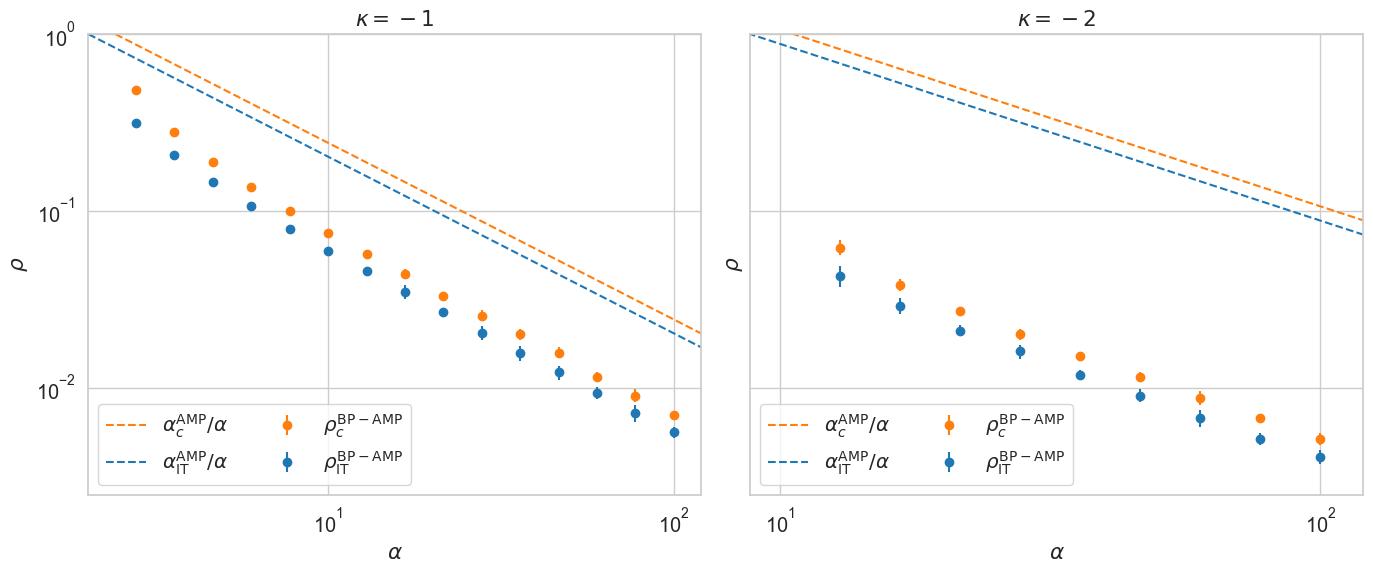

In [383]:
## Together c=0 and c=1
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
ax = axs[1]

ax.title.set_text(r'$\kappa=-2$')
ax.plot(np.linspace(1,200,1000),10.6/np.linspace(1,200,1000),'--',label=r'$\alpha_c^{\rm AMP} / \alpha$', color='tab:orange')
ax.errorbar(al_tab_2,rho_cc_tab_2,yerr=1.5*np.array(rho_sd_tab_2),fmt='o',label=r'$\rho_c^{\rm BP-AMP}$', color='tab:orange')
ax.plot(np.linspace(1,200,1000),8.8/np.linspace(1,200,1000),'--',label=r'$\alpha_{\rm IT}^{\rm AMP} / \alpha$', color='tab:blue')
ax.errorbar(al_tab_2,rho_IT_tab_2,yerr=1.5*np.array(rho_sd_tab_2),fmt='o',label=r'$\rho_{\rm IT}^{\rm BP-AMP}$', color='tab:blue')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\rho$')
ax.set_ylim(plt.ylim()[0], 1)
ax.set_xlim(8.8, 120)
#ax.axvline(7.9573, color='red', linestyle='--', label=r'$\alpha=\alpha_{\rm AMP}$')
ax.legend(ncol=2, loc='lower left')
plt.tight_layout()
#fig.savefig('rho_c_alpha_not.pdf')
ax = axs[0]
ax.title.set_text(r'$\kappa=-1$')
ax.plot(np.linspace(1,200,1000),2.425/np.linspace(1,200,1000),'--',label=r'$\alpha_c^{\rm AMP} / \alpha$', color='tab:orange')
ax.errorbar(al_tab_1,rho_cc_tab_1,yerr=1.5*np.array(rho_sd_tab_1),fmt='o',label=r'$\rho_c^{\rm BP-AMP}$', color='tab:orange')
ax.plot(np.linspace(1,200,1000),2.025/np.linspace(1,200,1000),'--',label=r'$\alpha_{\rm IT}^{\rm AMP} / \alpha$', color='tab:blue')
ax.errorbar(al_tab_1,rho_IT_tab_1,yerr=1.5*np.array(rho_sd_tab_1),fmt='o',label=r'$\rho_{\rm IT}^{\rm BP-AMP}$', color='tab:blue')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\rho$')
ax.set_ylim(plt.ylim()[0], 1)
ax.set_xlim(2.025, 120)
#ax.axvline(7.9573, color='red', linestyle='--', label=r'$\alpha=\alpha_{\rm AMP}$')
ax.legend(ncol=2, loc='lower left')

plt.tight_layout()
fig.savefig('rho_c_and_it.pdf')


# c = 0

In [58]:
load_Dir = "./CLUSTER/DataCxtEpi/data_critical/"

In [59]:
#file_name = "DF_20250217-c0_a2.xz"
file_name = "DF_20250520-095046_872.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame_tot = pickle.load(f)

In [60]:
a_ll = np.logspace(0,2,19,base=10)
print(a_ll**0.5*50000)

[ 50000.          56823.18331929  64577.48325074  73389.9633811
  83405.02686     94786.78262032 107721.73450159 122421.83734111
 139127.97011036 158113.88300842 179690.68319023 204211.93263373
 232079.44168064 263749.85318513 299742.12515947 340646.03452898
 387131.84134056 439961.27178455 500000.        ]


In [61]:
a_ll[2] = 70710/35356

In [62]:
i = 18
print(int(50000*a_ll[i]**0.5),a_ll[i])

500000 100.0


In [63]:
data_frame_tot[r"$\rho$"] = data_frame_tot["M"]

In [64]:
#if  int(10000*a_ll[i]**0.5) is odd, then add 1 to it
if int(50000*a_ll[i]**0.5)%2 == 1:
    N1 = int(50000*a_ll[i]**0.5) + 1
else:
    N1 = int(50000*a_ll[i]**0.5)

if int(10000*a_ll[i]**0.5)%2 == 1:
    N2 = int(10000*a_ll[i]**0.5) + 1
else:
    N2 = int(10000*a_ll[i]**0.5)

In [65]:
data_frame_tot[data_frame_tot[r"$N$"]==N1][r"$\rho$"].unique()

array([0.0105, 0.016 , 0.012 , 0.008 , 0.0085, 0.0145, 0.009 , 0.014 ,
       0.0155, 0.0125, 0.015 , 0.011 , 0.0095, 0.0135, 0.013 , 0.0115,
       0.01  ])

In [66]:
df = data_frame_tot[(data_frame_tot[r"$N$"]==N1) | (data_frame_tot[r"$N$"]==N2)]

<Axes: xlabel='$\\rho$', ylabel='$\\delta O_{t=0}$'>

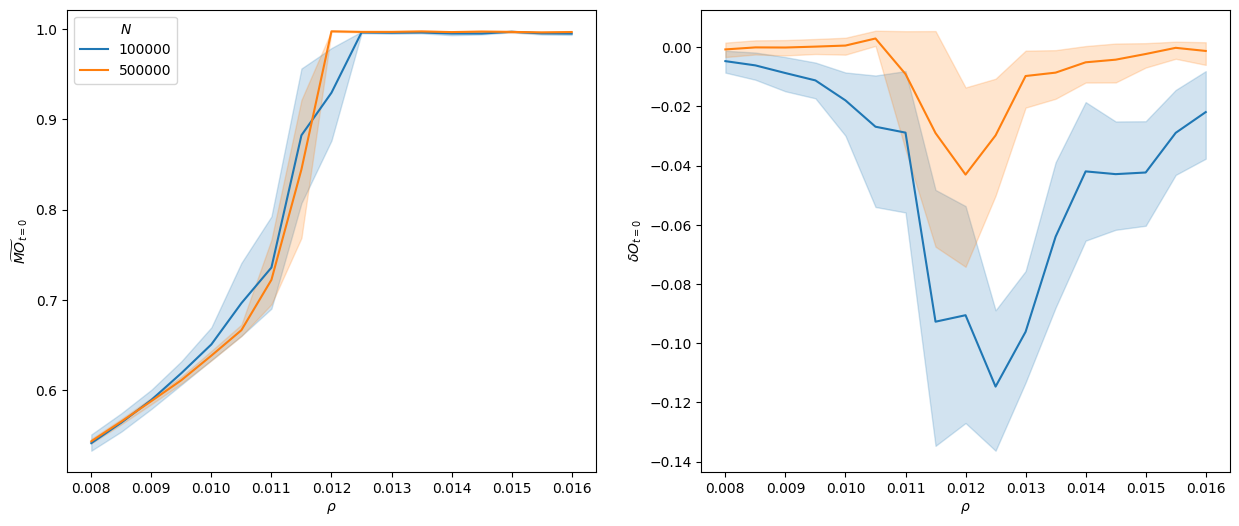

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(data=df,x=r"$\rho$",y=r"$\widetilde{MO}_{t=0}$", hue=r"$N$",errorbar="ci", palette="tab10",ax=axs[0])
sns.lineplot(data=df,x=r"$\rho$",y=r"$\delta O_{t=0}$", hue=r"$N$",errorbar="ci", palette="tab10",ax=axs[1],legend=False)

In [68]:
rho_cc_tab_0 = [0.685, 0.625, 0.461, 0.35, 0.27,
                0.205, 0.155, 0.119, 0.092, 0.072,
                0.055, 0.0425, 0.034, 0.0255, 0.02,
                0.015, 0.012
               ]    
rho_sd_tab_0 = 2*np.array([0.01, 0.01, 0.01, 0.01, 0.005,
                0.005, 0.005, 0.005, 0.004, 0.004,
                0.002, 0.002, 0.002, 0.001, 0.001,
                0.001, 0.0005])
al_tab_0 = a_ll[2:]

In [69]:
al_tab_0

array([  1.99994343,   2.15443469,   2.7825594 ,   3.59381366,
         4.64158883,   5.9948425 ,   7.74263683,  10.        ,
        12.91549665,  16.68100537,  21.5443469 ,  27.82559402,
        35.93813664,  46.41588834,  59.94842503,  77.42636827,
       100.        ])

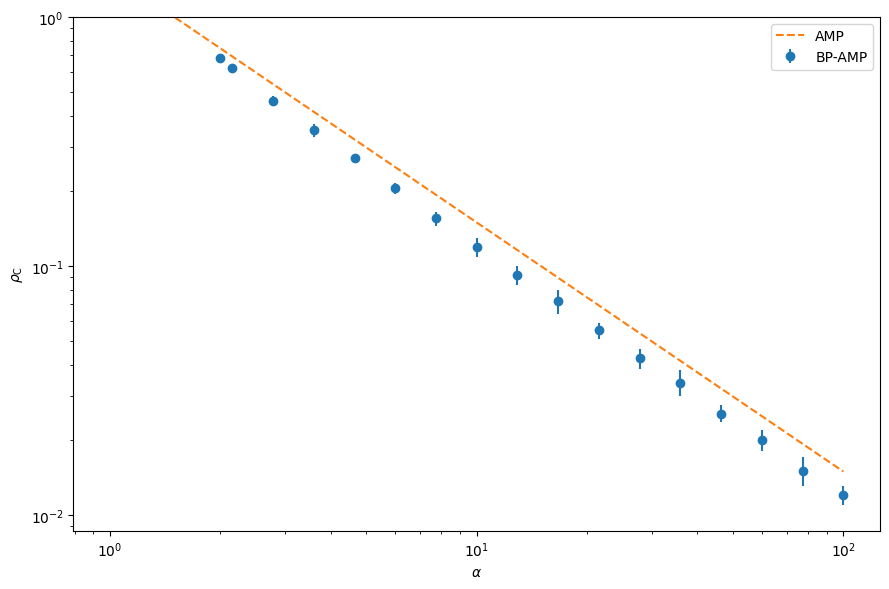

In [70]:
fig, ax = plt.subplots(figsize=(9, 6))
#fig.suptitle(r'$\rho_C(\alpha)$ for $\kappa=-1$')
ax.errorbar(al_tab_0,rho_cc_tab_0,yerr=rho_sd_tab_0,fmt='o',label='BP-AMP')
ax.plot(np.linspace(1,100,1000),alpha_amp_tab[1]/np.linspace(1,100,1000),'--',label="AMP")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\rho_{\rm C}$')
ax.legend()

ax.set_ylim(plt.ylim()[0], 1)

plt.tight_layout()
#fig.savefig('rho_c_alpha_not.pdf')

In [88]:
N_tab = (np.ceil(np.sqrt(a_ll[9:])*10000/2.)*2.).astype(int)
M_tab = np.round(10000/(np.sqrt(a_ll[9:]))).astype(int)
print(N_tab)

[ 31624  35940  40844  46416  52750  59950  68130  77428  87994 100000]


In [89]:
print(M_tab)

[3162 2783 2448 2154 1896 1668 1468 1292 1136 1000]


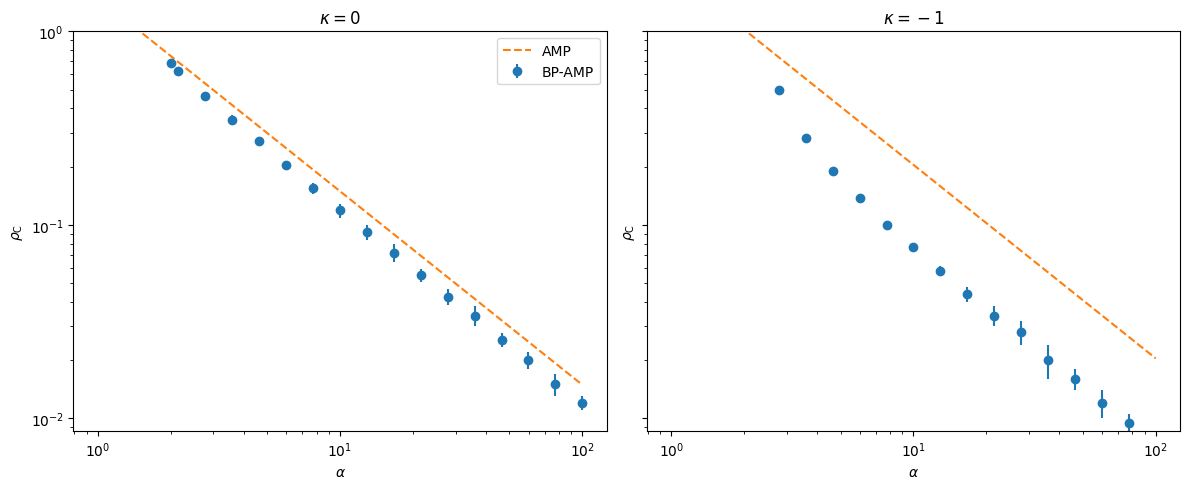

In [71]:
# put the plots fpr c=0 and c=1 side by side

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
#fig.suptitle(r'$\rho_C(\alpha)$ for $\kappa=-1$')
ax = axs[0]
ax.errorbar(al_tab_0,rho_cc_tab_0,yerr=rho_sd_tab_0,fmt='o',label='BP-AMP')
ax.plot(np.linspace(1,100,1000),alpha_amp_tab[1]/np.linspace(1,100,1000),'--',label="AMP")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\rho_{\rm C}$')
ax.legend()
ax.set_title(r'$\kappa=0$')
ax.set_ylim(plt.ylim()[0], 1)
ax = axs[1]
ax.errorbar(al_tab,rho_cc_tab,yerr=rho_sd_tab,fmt='o',label='BP-AMP')
ax.plot(np.linspace(1,100,1000),alpha_amp_tab[2]/np.linspace(1,100,1000),'--',label="AMP")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\rho_{\rm C}$')
#ax.legend()
ax.set_title(r'$\kappa=-1$')
ax.set_ylim(plt.ylim()[0], 1)
plt.tight_layout()
fig.savefig('rho_c_alpha_not.pdf')

# Prove

In [ ]:
load_Dir = "./CLUSTER/DataCxtEpi/data_critical/"

In [1180]:
#file_name = "DF_20250217-c0_a2.xz"
file_name = "DF_CtxtEpiGLM_d3rrg_N24000_lam1.0_del[0.5]_rho[0.18]_c1.0_M4000_uRad1_init0_seed4.xz"
#file_name = "DF_20250519-090717_216.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame_tot = pickle.load(f)

In [1181]:
data_frame_tot.iloc[:,-10:]

,$SE_{RND}$,$MSE_{RND}$,$\delta SE$,$R_{SE}$,$R_{MSE}$,$\delta R_{SE}$,ConvChecks,free_entropy_BP,free_entropy_AMP,total_free_entropy
0,1.012843,1.011885,-0.004094,0.995684,0.991634,0.00405,"[[10, 0.0678432495226996, 3.051547227645082e-0...",0.314126,-0.429838,-0.115712


In [9]:
a_ll = np.logspace(0,np.log10(50),20,base=10)
print(np.round(40000/a_ll).astype(int))

[40000 32557 26498 21568 17554 14288 11629  9465  7704  6270  5103  4154
  3381  2752  2240  1823  1484  1208   983   800]


In [1154]:
i = 7
print(int(50000*a_ll[i]**0.5),a_ll[i])

122421 5.994842503189409


In [1155]:
data_frame_tot[r"$\rho$"] = data_frame_tot["M"]
data_frame_tot["c"].unique()

array([1.])

In [1156]:
#if  int(10000*a_ll[i]**0.5) is odd, then add 1 to it
if int(50000*a_ll[i]**0.5)%2 == 1:
    N = int(50000*a_ll[i]**0.5) + 1
else:
    N = int(50000*a_ll[i]**0.5)

In [1157]:
data_frame_tot[data_frame_tot[r"$N$"]==N][r"$\rho$"].unique()

array([0.1  , 0.145, 0.14 , 0.135, 0.12 , 0.125, 0.105, 0.11 , 0.15 ,
       0.115, 0.13 ])

In [1158]:
df = data_frame_tot[(data_frame_tot[r"$\widetilde{MO}_{t=0}$"] - data_frame_tot[r"$\widetilde{O}_{t=0}$"]) <0.0001]
len(df)

1689

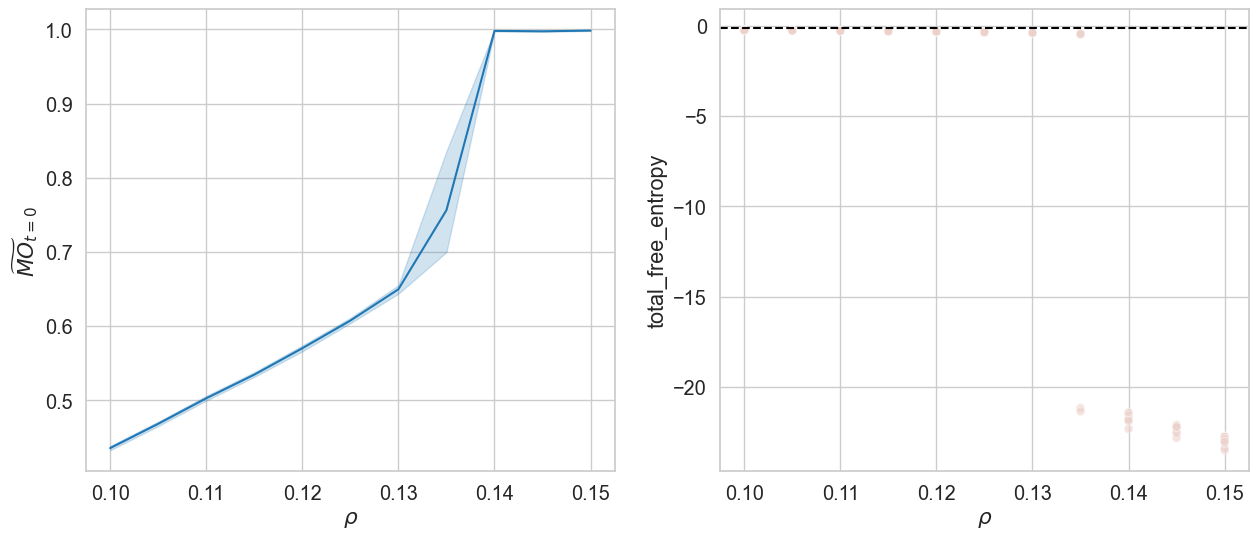

In [1159]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y=r"$\widetilde{MO}_{t=0}$", hue=r"$N$",errorbar="ci", palette="tab10",ax=axs[0],legend=False)
sns.scatterplot(data=df[df[r"$N$"]==N],x=r"$\rho$",y="total_free_entropy", hue=r"$N$",alpha=0.6, s=40, ax=axs[1],legend=False)
axs[1].axhline(-np.log(2)/a_ll[i], color='black', linestyle='--')

In [343]:
file_name = "DF_20250621-criticalAMP_c2.xz"
#file_name = "DF_20250519-090717_216.xz"
data_frame = pd.read_pickle("./CLUSTER/DataCxtEpi/data_new/" + file_name)

In [344]:
data_frame = data_frame[data_frame[r"$O_{t=0}$"] - data_frame[r"$MO_{t=0}$"] < 1]

In [345]:
alphas = sorted(data_frame[r"$\alpha$"].unique())

In [349]:
np.array(alphas)

array([ 8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ,
       10.2, 10.4, 10.6, 10.8, 11. , 11.2, 11.4, 11.6, 11.8, 12. ])

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_14295/2052341644.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=data_frame,x=r"$\alpha$",y=r"$\log Z$", palette="tab10",ax=ax,legend=False)


(-0.1, 0.0)

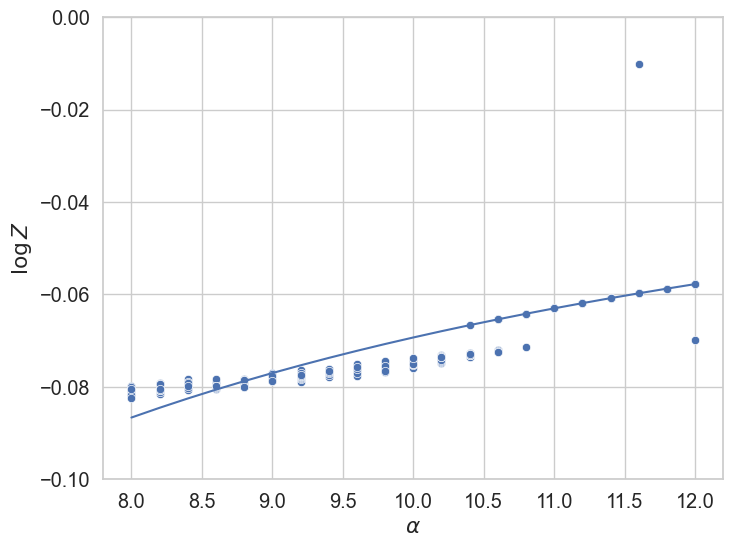

In [347]:
sns.set_theme(style="whitegrid",font_scale=1.3)
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=data_frame,x=r"$\alpha$",y=r"$\log Z$", palette="tab10",ax=ax,legend=False)
plt.plot(alphas,-np.log(2)/alphas)
ax.set_ylim(-0.1, 0)


In [24]:
-np.log(2)/1.25

np.float64(-0.5545177444479562)

In [25]:
data_frame[r"$\log Z$"]

0   -0.563823
1   -0.562437
2   -0.555970
3   -0.551001
4   -0.537915
5   -0.537658
6   -0.531768
7   -0.462345
8   -0.447557
Name: $\log Z$, dtype: float64

# 2x2 critical plot

In [2331]:
load_Dir = "./CLUSTER/DataCxtEpi/data_new/"

In [2332]:
#file_name = "DF_20250217-c0_a2.xz"
file_name = "DF_20250703-142005_162.xz"
with lzma.open(load_Dir + file_name, "rb") as f:
    data_frame_tot = pickle.load(f)

In [2333]:
#data_frame_tot.iloc[:,-10:]
data_frame_tot[r"$\rho$"] = data_frame_tot["M"]

In [2334]:
np.array(sorted(data_frame_tot[r"$N$"].unique())) / np.flip(np.array(sorted(data_frame_tot[r"$M$"].unique())))

array([  4.9998323 ,   9.03983764,   9.50982962,  10.        ,
        11.31970729,  12.10018262,  12.91572327,  16.68041658,
        21.54351358,  27.82513517,  35.94004796,  46.4173054 ,
        59.95044522,  77.42366916, 100.        ])

In [2335]:
sorted(data_frame_tot[r"$M$"].unique())

[np.int64(4000),
 np.int64(4546),
 np.int64(5166),
 np.int64(5871),
 np.int64(6672),
 np.int64(7583),
 np.int64(8618),
 np.int64(9794),
 np.int64(11130),
 np.int64(11499),
 np.int64(11889),
 np.int64(12649),
 np.int64(12971),
 np.int64(13304),
 np.int64(17889)]

In [2336]:
Ns = np.array([89442, 126490, 185662])

In [2337]:
df0 = data_frame_tot[data_frame_tot[r"$N$"] == Ns[0]]
df1 = data_frame_tot[(data_frame_tot[r"$N$"] == Ns[1]) & (data_frame_tot[r"$M$"] == 12649) & ((data_frame_tot[r"$\rho$"] == 0.) | (data_frame_tot[r"$\rho$"] == 0.1) | (data_frame_tot[r"$\rho$"] == 0.2) | (data_frame_tot[r"$\rho$"] == 0.3) | (data_frame_tot[r"$\rho$"] == 0.4) | (data_frame_tot[r"$\rho$"] == 0.5) | (data_frame_tot[r"$\rho$"] == 0.6) | (data_frame_tot[r"$\rho$"] == 0.7) | (data_frame_tot[r"$\rho$"] == 0.8) | (data_frame_tot[r"$\rho$"] == 0.9) | (data_frame_tot[r"$\rho$"] == 1.))]
df2 = data_frame_tot[data_frame_tot[r"$N$"] == Ns[2]]

In [2338]:
df2[r"$M$"].unique()

array([8618])

In [2339]:
l = len(df0)
print(l)
i=0
while (i < l-1):
    dict = {}
    dict[r"$\rho$"] = df0.iloc[i][r"$\rho$"]
    dict[r"delta_free_entropy"] = df0.iloc[i][r"total_free_entropy"] - df0.iloc[i+1][r"total_free_entropy"]
    dict["delta_O"] = df0.iloc[i][r"$O_{t=0}$"] - df0.iloc[i][r"$MO_{t=0}$"]
    dict[r"$\widetilde{O}_{t=0}$"] = df0.iloc[i][r"$\widetilde{O}_{t=0}$"]
    dict[r"$1-\widetilde{O}_{t=0}$"] = 1 - df0.iloc[i][r"$\widetilde{O}_{t=0}$"]

    if i == 0:
        df_diff0 = pd.DataFrame(dict, index=[0])
    else:
        df_diff0 = pd.concat([df_diff0, pd.DataFrame(dict, index=[0])], ignore_index=True)
    i += 2

len(df_diff0)

220


110

In [2340]:
l = len(df1)
print(l)
i=0
while (i < l-1):
    dict = {}
    dict[r"$\rho$"] = df1.iloc[i][r"$\rho$"]
    dict[r"delta_free_entropy"] = df1.iloc[i][r"total_free_entropy"] - df1.iloc[i+1][r"total_free_entropy"]
    dict["delta_O"] = df1.iloc[i][r"$O_{t=0}$"] - df1.iloc[i][r"$MO_{t=0}$"]
    dict[r"$\widetilde{O}_{t=0}$"] = df1.iloc[i][r"$\widetilde{O}_{t=0}$"]
    dict[r"$1-\widetilde{O}_{t=0}$"] = 1 - df1.iloc[i][r"$\widetilde{O}_{t=0}$"]
    

    if i == 0:
        df_diff1 = pd.DataFrame(dict, index=[0])
    else:
        df_diff1 = pd.concat([df_diff1, pd.DataFrame(dict, index=[0])], ignore_index=True)
    i += 2

len(df_diff1)

220


110

In [2341]:
l = len(df2)
print(l)
i=0
while (i < l-1):
    dict = {}
    dict[r"$\rho$"] = df2.iloc[i][r"$\rho$"]
    dict[r"delta_free_entropy"] = df2.iloc[i][r"total_free_entropy"] - df2.iloc[i+1][r"total_free_entropy"]
    dict["delta_O"] = df2.iloc[i][r"$O_{t=0}$"] - df2.iloc[i][r"$MO_{t=0}$"]
    dict[r"$\widetilde{O}_{t=0}$"] = df2.iloc[i][r"$\widetilde{O}_{t=0}$"]
    dict[r"$1-\widetilde{O}_{t=0}$"] = 1 - df2.iloc[i][r"$\widetilde{O}_{t=0}$"]
    

    if i == 0:
        df_diff2 = pd.DataFrame(dict, index=[0])
    else:
        df_diff2 = pd.concat([df_diff2, pd.DataFrame(dict, index=[0])], ignore_index=True)
    i += 2

len(df_diff2)

408


204

In [2342]:
df_diff_0 = df_diff0[(abs(df_diff0["delta_O"]) < 0.001) & (abs(df_diff0["delta_free_entropy"]) <0.2)]
df_diff_1 = df_diff1[(abs(df_diff1["delta_O"]) < 0.0001) & (abs(df_diff1["delta_free_entropy"]) <0.2)]
df_diff_2 = df_diff2[(abs(df_diff2["delta_O"]) < 0.01) & (abs(df_diff2["delta_free_entropy"]) <0.01)]
len(df_diff_1)

76

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_39037/3991245868.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax.axhline(0., color=plt.cm.get_cmap('tab10')(0), linestyle='--')


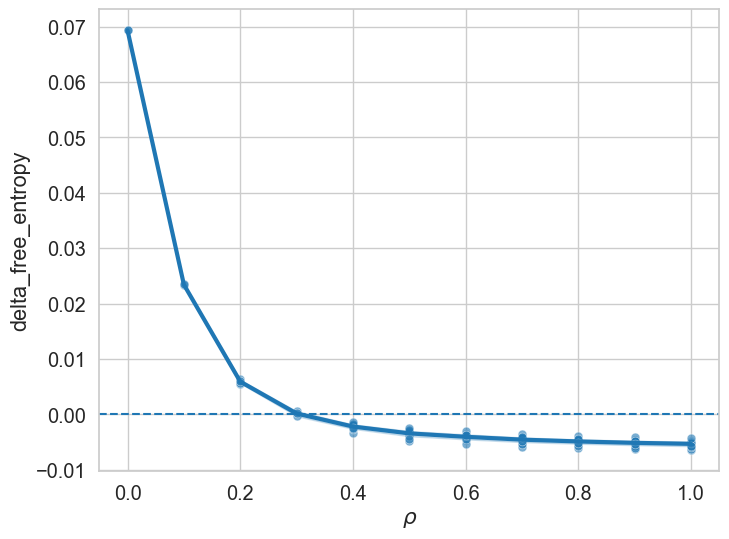

In [2343]:
fig, ax = plt.subplots( figsize=(8, 6))
#fig.suptitle(r'$\kappa=2$, $N * M = 2.5 \times 10^9$, $\alpha=12.91$')
y_s = r"delta_free_entropy"#"total_free_entropy"
sns.scatterplot(data=df_diff_1,x=r"$\rho$",y=y_s, alpha=0.6, s=40, ax=ax, legend=False, color="tab:blue")
sns.lineplot(data=df_diff_1,x=r"$\rho$",y=y_s, errorbar="ci", linewidth=3, ax=ax, color="tab:blue")
#sns.scatterplot(data=df_inf,x=r"$\rho$",y=y_s, alpha=0.6, s=40, ax=ax, legend=False, color="tab:orange")
#sns.lineplot(data=df_inf,x=r"$\rho$",y=y_s, errorbar="ci", linewidth=3, ax=ax, color="tab:orange")



ax.axhline(0., color=plt.cm.get_cmap('tab10')(0), linestyle='--')
#ax.axhline(-np.log(2)/4, color=plt.cm.get_cmap('tab10')(1), linestyle='--')
#ax.axhline(-np.log(2)/8, color=plt.cm.get_cmap('tab10')(2), linestyle='--')
#ax.set_xlim(0.065, 0.1)

Text(0, 0.5, '$1-\\widetilde{O}_{t=0}$')

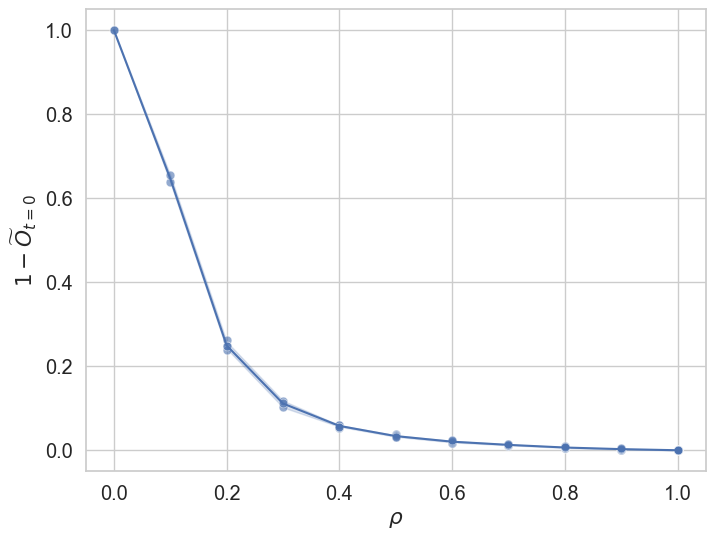

In [2344]:
fig, ax = plt.subplots( figsize=(8, 6))
#fig.suptitle(r'$\kappa=-2$, $N * M =  10^8$, $\lambda=0.5$')
sns.lineplot(data=df_diff_1,x=r"$\rho$",y=r"$1-\widetilde{O}_{t=0}$",errorbar="ci",legend=False,)
sns.scatterplot(data=df_diff_1,x=r"$\rho$",y=r"$1-\widetilde{O}_{t=0}$", alpha=0.6, s=40, ax=ax,)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$1-\widetilde{O}_{t=0}$")
#ax.set_xlim(0.065, 0.1)
#ax.set_yscale('log')#, linthresh=0.000001)
#fig.savefig("out.pdf")

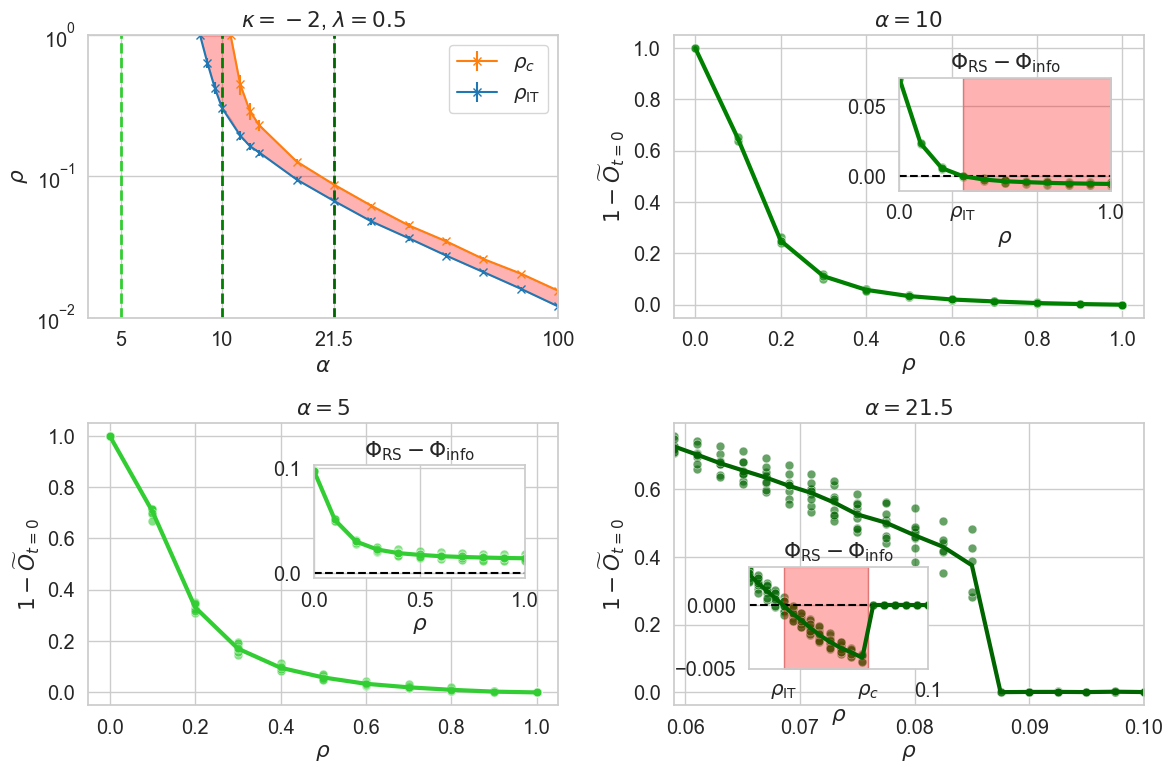

In [2347]:
# 2x2 plot, in each $1-\widetilde{O}_{t=0}$" as inset and r"delta_free_entropy" as main plot. One blank, one df_diff_0, one df_diff_1, one df_diff_2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

ax = axs[0,0]
ax.set_title(r'$\kappa=-2$, $\lambda=0.5$')
ax.errorbar(al_tab_2_l5,rho_cc_tab_2_l5,yerr=rho_sd_tab_2_l5,fmt='x-',label=r'$\rho_c$', color='tab:orange')
ax.errorbar(al_tab_IT_2_l5,rho_IT_tab_2_l5,yerr=rho_sd_IT_tab_2_l5,fmt='x-',label=r'$\rho_{\rm IT}$', color='tab:blue')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\rho$')
ax.set_ylim(1e-2, 1)
ax.set_xlim(4, 100)
#ax.axvline(7.9573, color='red', linestyle='--', label=r'$\alpha=\alpha_{\rm AMP}$')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right')

x_start = 8.6
x_end = 100

x1 = al_tab_2_l5
y1 = rho_cc_tab_2_l5

x2 = al_tab_IT_2_l5
y2 = rho_IT_tab_2_l5

y_start = 1#y1[0] if x_start == x1[0] else y2[0]
y1_end = y1[-1] if x_end == x1[-1] else y2[-1]
y2_end = y2[-1]# if x_end == x1[-1] else y2[-1]

# Ensure all points from x1 and x2 are included in the interpolation
x_combined = sorted(set(np.r_[x_start, x1, x2, x_end]))
y1_combined = np.interp(x_combined, np.r_[x_start, x1, x_end], np.r_[y_start, y1, y1_end])
y2_combined = np.interp(x_combined, np.r_[x_start, x2, x_end], np.r_[y_start, y2, y2_end])

# Add the last point explicitly to ensure it is included
x_combined.append(x_end)
y1_combined = np.append(y1_combined, y1[-1])
y2_combined = np.append(y2_combined, y2[-1])

ax.axvline(x=5, linestyle='--', linewidth=2, color='limegreen')
ax.axvline(x=10, linestyle='--', linewidth=2, color='green')
ax.axvline(x=21.5, linestyle='--', linewidth=2, color='darkgreen')
ax.set_xticks([5, 10, 21.5, 100])
ax.set_xticklabels([5, 10, 21.5, 100])

# Fill the area between the two interpolated curves
ax.fill_between(x_combined, y1_combined, y2_combined, color="red", alpha=0.3)

ax = axs[1, 0]
ax.set_title(r'$\alpha=5$')
ys_2 = "delta_free_entropy"
ys_1 = r"$1-\widetilde{O}_{t=0}$" 
sns.lineplot(data=df_diff_0,x=r"$\rho$",y=ys_1, errorbar=None, linewidth=3, ax=ax,color="limegreen")
sns.scatterplot(data=df_diff_0,x=r"$\rho$",y=ys_1, alpha=0.6, s=40, ax=ax,color="limegreen")
#plot of logZ vs rho as inset
axins = ax.inset_axes([0.48, 0.45, 0.45, 0.4])  # [x, y, width, height]
axins.axhline(0., color='black', linestyle='--')
sns.lineplot(data=df_diff_0,x=r"$\rho$",y=ys_2, ax=axins, errorbar=None, linewidth=3,color="limegreen")
sns.scatterplot(data=df_diff_0,x=r"$\rho$",y=ys_2, alpha=0.6, s=40, ax=axins,color="limegreen")
axins.set_xlabel(r"$\rho$")
axins.set_ylabel("")
axins.set_xlim(0., 1.)
ax.set_ylabel(ys_1)
axins.set_title(r"$\Phi_{\rm RS} - \Phi_{\rm info}$")

ax = axs[0, 1]
ax.set_title(r'$\alpha=10$')
ys_2 = "delta_free_entropy"
ys_1 = r"$1-\widetilde{O}_{t=0}$" 
sns.lineplot(data=df_diff_1,x=r"$\rho$",y=ys_1, errorbar=None, linewidth=3, ax=ax,color="green")
sns.scatterplot(data=df_diff_1,x=r"$\rho$",y=ys_1, alpha=0.6, s=40, ax=ax,color="green")
#plot of logZ vs rho as inset
axins = ax.inset_axes([0.48, 0.45, 0.45, 0.4])  # [x, y, width, height]
axins.axhline(0., color='black', linestyle='--')
sns.lineplot(data=df_diff_1,x=r"$\rho$",y=ys_2, ax=axins, errorbar=None, linewidth=3,color="green")
sns.scatterplot(data=df_diff_1,x=r"$\rho$",y=ys_2, alpha=0.6, s=40, ax=axins,color="green")
axins.set_xlabel(r"$\rho$")
axins.set_ylabel("")
axins.set_xlim(0., 1.)
axins.set_ylim(-0.01, 0.07)
ax.set_ylabel(ys_1)
axins.set_title(r"$\Phi_{\rm RS} - \Phi_{\rm info}$")
x = [0.3,1]
y = [axins.get_ylim()[0], axins.get_ylim()[1]]
axins.fill_between(x, y[0], y[1], color='red', alpha=0.3)
axins.set_xticks([0., 0.3 , 1.])
axins.set_xticklabels([0.0, r"$\rho_{\rm IT}$", 1.0])

ax = axs[1,1]
ax.set_title(r'$\alpha=21.5$')
ys_2 = "delta_free_entropy"
ys_1 = r"$1-\widetilde{O}_{t=0}$" 
sns.lineplot(data=df_diff_2,x=r"$\rho$",y=ys_1, errorbar=None, linewidth=3, ax=ax,color="darkgreen")
sns.scatterplot(data=df_diff_2,x=r"$\rho$",y=ys_1, alpha=0.6, s=40, ax=ax,color="darkgreen")
#plot of logZ vs rho as inset
axins = ax.inset_axes([0.16, 0.13, 0.38, 0.36])  # [x, y, width, height]
axins.axhline(0., color='black', linestyle='--')
sns.lineplot(data=df_diff_2,x=r"$\rho$",y=ys_2, ax=axins, errorbar=None, linewidth=3,color="darkgreen")
sns.scatterplot(data=df_diff_2,x=r"$\rho$",y=ys_2, alpha=0.6, s=40, ax=axins,color="darkgreen")
axins.set_xlabel(r"$\rho$")
axins.set_ylabel("")
ax.set_ylabel(ys_1)
axins.set_title(r"$\Phi_{\rm RS} - \Phi_{\rm info}$")
ax.set_xlim(0.059, 0.1)
axins.set_ylim(-0.005, 0.003)
axins.set_xlim(0.059, 0.1)
#axins.set_xticks([0.07, 0.08, 0.09, 0.1])
axins.set_xticks([0.067, 0.08625 , 0.1])
axins.set_xticklabels([r"$\rho_{\rm IT}$", r"$\rho_{c}$", 0.1])
x = [0.067,0.08625]
y = [axins.get_ylim()[0], axins.get_ylim()[1]]
axins.fill_between(x, y[0], y[1], color='red', alpha=0.3)

fig.tight_layout()
fig.savefig("Summary_PhTr.pdf", bbox_inches='tight')

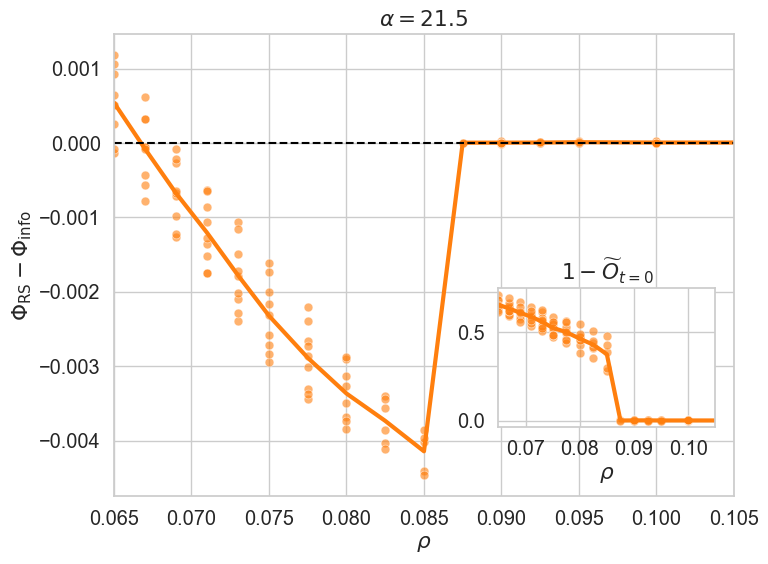

In [2235]:
fig,ax = plt.subplots(figsize=(8, 6))
ax.set_title(r'$\alpha=21.5$')
ys_1 = "delta_free_entropy"
ys_2 = r"$1-\widetilde{O}_{t=0}$" 
sns.lineplot(data=df_diff_2,x=r"$\rho$",y=ys_1, errorbar=None, linewidth=3, ax=ax,color="tab:orange")
sns.scatterplot(data=df_diff_2,x=r"$\rho$",y=ys_1, alpha=0.6, s=40, ax=ax,color="tab:orange")
#plot of logZ vs rho as inset
axins = ax.inset_axes([0.62, 0.15, 0.35, 0.3])  # [x, y, width, height]
ax.axhline(0., color='black', linestyle='--')
sns.lineplot(data=df_diff_2,x=r"$\rho$",y=ys_2, ax=axins, errorbar=None, linewidth=3,color="tab:orange")
sns.scatterplot(data=df_diff_2,x=r"$\rho$",y=ys_2, alpha=0.6, s=40, ax=axins,color="tab:orange")
axins.set_xlabel(r"$\rho$")
axins.set_ylabel("")
axins.set_title(ys_2)
ax.set_ylabel(r"$\Phi_{\rm RS} - \Phi_{\rm info}$")
ax.set_xlim(0.065, 0.105)
axins.set_xlim(0.065, 0.105)
axins.set_xticks([0.07, 0.08, 0.09, 0.1])
#axins.set_xticklabels([0.003, r"$\rho_{\rm IT}$", r"$\rho_{c}$", 0.007])
#axins.set_yticks([-0.005, -0.007, -0.009])
#axins.set_xlim(0.0029,0.0071)
#axins.set_ylim(-0.009,-0.0048)

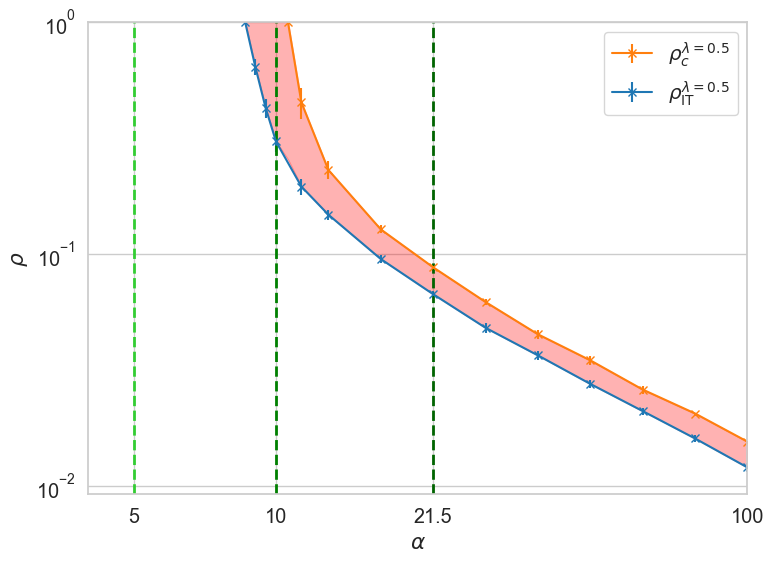

In [2233]:
sns.set_theme(style="whitegrid", font_scale=1.3)
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(al_tab_2_l5,rho_cc_tab_2_l5,yerr=rho_sd_tab_2_l5,fmt='x-',label=r'$\rho_c^{\lambda=0.5}$', color='tab:orange')
ax.errorbar(al_tab_IT_2_l5,rho_IT_tab_2_l5,yerr=rho_sd_IT_tab_2_l5,fmt='x-',label=r'$\rho_{\rm IT}^{\lambda=0.5}$', color='tab:blue')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\rho$')
ax.set_ylim(plt.ylim()[0], 1)
ax.set_xlim(4, 100)
#ax.axvline(7.9573, color='red', linestyle='--', label=r'$\alpha=\alpha_{\rm AMP}$')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right')
plt.tight_layout()

x_start = 8.6
x_end = 100

x1 = al_tab_2_l5
y1 = rho_cc_tab_2_l5

x2 = al_tab_IT_2_l5
y2 = rho_IT_tab_2_l5

y_start = 1#y1[0] if x_start == x1[0] else y2[0]
y1_end = y1[-1] if x_end == x1[-1] else y2[-1]
y2_end = y2[-1]# if x_end == x1[-1] else y2[-1]

# Ensure all points from x1 and x2 are included in the interpolation
x_combined = sorted(set(np.r_[x_start, x1, x2, x_end]))
y1_combined = np.interp(x_combined, np.r_[x_start, x1, x_end], np.r_[y_start, y1, y1_end])
y2_combined = np.interp(x_combined, np.r_[x_start, x2, x_end], np.r_[y_start, y2, y2_end])

# Add the last point explicitly to ensure it is included
x_combined.append(x_end)
y1_combined = np.append(y1_combined, y1[-1])
y2_combined = np.append(y2_combined, y2[-1])

ax.axvline(x=5, linestyle='--', linewidth=2, color='limegreen')
ax.axvline(x=10, linestyle='--', linewidth=2, color='green')
ax.axvline(x=21.5, linestyle='--', linewidth=2, color='darkgreen')
ax.set_xticks([5, 10, 21.5, 100])
ax.set_xticklabels([5, 10, 21.5, 100])

# Fill the area between the two interpolated curves
plt.fill_between(x_combined, y1_combined, y2_combined, color="red", alpha=0.3)